# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

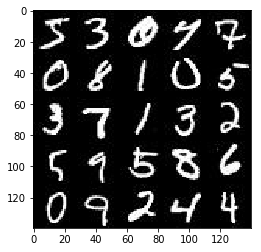

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

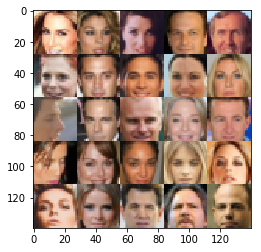

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_ = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="input")
    z_data = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="z_data")
    lr = tf.placeholder(dtype=tf.float32, shape=(), name="learnings_rate")
    
    return input_, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [84]:
def leaky_relu(x, alpha=0.1, name=None):
    return tf.maximum(x*alpha, x, name=name)
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope("discriminator", reuse=reuse):
        # images have a shape of 28x28xchannels
        conv0 = tf.layers.conv2d(images, filters=8, kernel_size=(7, 7), strides=(1, 1), padding="same", activation=None)
        relu0 = leaky_relu(conv0)
        
        # 28x28x8
        conv1 = tf.layers.conv2d(relu0, filters=16, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        relu1 = leaky_relu(conv1)
        
        # 14x14x16
        conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        relu2 = leaky_relu(conv2)
        
        # 7x7x64
        flat = tf.reshape(relu2, shape=(-1, 7*7*64))
        conn1 = tf.layers.dense(flat, 256)
        relu3 = leaky_relu(conn1)
        
        # 256
        logit = tf.layers.dense(relu3, 1)
        out = tf.sigmoid(logit)
        
    return out, logit


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [82]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope("generator", reuse=not is_train):
        conn1 = tf.layers.dense(z, 256)
        relu1 = leaky_relu(conn1)
        
        # 256
        conn2 = tf.layers.dense(relu1, 7*7*64)
        conn2_bn = tf.layers.batch_normalization(conn2, training=is_train)
        conn2_relu = leaky_relu(conn2_bn)
        
        imagey = tf.reshape(conn2_relu, shape=(-1, 7, 7, 64))
        
        # 7x7x64
        conv1 = tf.layers.conv2d_transpose(imagey, filters=16, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        conv1_bn = tf.layers.batch_normalization(conv1, training=is_train)
        conv1_relu = leaky_relu(conv1_bn)
        
        # 14x14x16
        conv2 = tf.layers.conv2d_transpose(conv1_relu, filters=8, kernel_size=(7, 7), strides=(2, 2), padding="same", activation=None)
        conv2_bn = tf.layers.batch_normalization(conv2, training=is_train)
        conv2_relu = leaky_relu(conv2_bn)
        
        # 28x28x8
        conv2 = tf.layers.conv2d_transpose(conv2_relu, filters=out_channel_dim, kernel_size=(7, 7), strides=(1, 1), padding="same", activation=None)
        
        # 28x28xout_channel_dim
        out = tf.tanh(conv2)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [34]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_fake = generator(input_z, out_channel_dim=out_channel_dim, is_train=True)
    
    disc_real_out, disc_real_logits = discriminator(input_real, reuse=False)
    disc_fake_out, disc_fake_logits = discriminator(input_fake, reuse=True)
    
    loss = lambda **kwargs: tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(**kwargs))
    
    disc_real_loss = loss(logits=disc_real_logits, labels=tf.ones_like(disc_real_out))
    disc_fake_loss = loss(logits=disc_fake_logits, labels=tf.zeros_like(disc_fake_out))
    disc_loss = disc_real_loss + disc_fake_loss
    
    gen_loss = loss(logits=disc_fake_logits, labels=tf.ones_like(disc_fake_out))
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [85]:
def minimize_with_clip(optimizer, loss, var_list):
    # Gradient Clipping
    gradients = optimizer.compute_gradients(loss, var_list=var_list)
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
    train_op = optimizer.apply_gradients(capped_gradients)
    
    return train_op

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable = tf.trainable_variables()
    disc_vars = [var for var in trainable if var.name.startswith('discriminator')]
    gen_vars = [var for var in trainable if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disc_optimizer = minimize_with_clip(
            tf.train.AdamOptimizer(learning_rate, beta1=beta1), loss=d_loss, var_list=disc_vars)
        gen_optimizer = minimize_with_clip(
            tf.train.AdamOptimizer(learning_rate, beta1=beta1), loss=g_loss, var_list=gen_vars)

    return disc_optimizer, gen_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [86]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [87]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Build model.
    nr_inputs, image_width, image_height, image_channels = data_shape

    input_, z_data, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    discriminator_loss, generator_loss = model_loss(input_, z_data, image_channels)
    discriminator_optimizer, generator_optimizer = model_opt(discriminator_loss, generator_loss, learning_rate, beta1)
    
    # Fixed sample inputs.
    nr_samples = 16

    # Train network.
    saver = tf.train.Saver()
    
    batch_i = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_i += 1
                
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                feed = {input_: batch_images, z_data: z_batch, lr: learning_rate}
                
                sess.run([discriminator_optimizer,generator_optimizer], feed_dict=feed)
                
                if batch_i % 10 == 0:
                    discriminator_train_loss, generator_train_loss = sess.run([discriminator_loss, generator_loss], feed_dict=feed)
                    
                    print("Epoch {}, batch {}: discriminator loss {:.4f}, generator loss {:.4f}".format(
                        epoch_i, batch_i, discriminator_train_loss, generator_train_loss))
                    
                if batch_i % 100 == 0:
                    show_generator_output(sess, nr_samples, z_data, image_channels, data_image_mode)
                    
                    
        saver.save(sess, './checkpoints/1.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0, batch 10: discriminator loss 1.9638, generator loss 0.1782
Epoch 0, batch 20: discriminator loss 1.2043, generator loss 0.6183
Epoch 0, batch 30: discriminator loss 0.1425, generator loss 5.4559
Epoch 0, batch 40: discriminator loss 0.8493, generator loss 2.1064
Epoch 0, batch 50: discriminator loss 1.5289, generator loss 0.6033
Epoch 0, batch 60: discriminator loss 1.0545, generator loss 1.2963
Epoch 0, batch 70: discriminator loss 1.0401, generator loss 0.7779
Epoch 0, batch 80: discriminator loss 1.9438, generator loss 0.2498
Epoch 0, batch 90: discriminator loss 0.8626, generator loss 2.3784
Epoch 0, batch 100: discriminator loss 0.6260, generator loss 1.3128


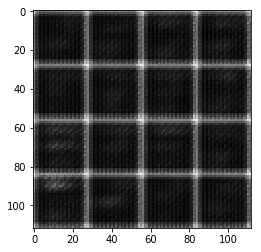

Epoch 0, batch 110: discriminator loss 1.2053, generator loss 0.4856
Epoch 0, batch 120: discriminator loss 0.5447, generator loss 1.6509
Epoch 0, batch 130: discriminator loss 0.4451, generator loss 2.7637
Epoch 0, batch 140: discriminator loss 0.5760, generator loss 1.7536
Epoch 0, batch 150: discriminator loss 1.5246, generator loss 0.4059
Epoch 0, batch 160: discriminator loss 0.8228, generator loss 1.2967
Epoch 0, batch 170: discriminator loss 0.7241, generator loss 1.1591
Epoch 0, batch 180: discriminator loss 0.8323, generator loss 1.3333
Epoch 0, batch 190: discriminator loss 0.8230, generator loss 1.5264
Epoch 0, batch 200: discriminator loss 0.8803, generator loss 0.6803


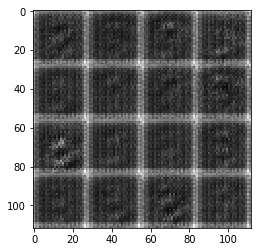

Epoch 0, batch 210: discriminator loss 0.8518, generator loss 1.3801
Epoch 0, batch 220: discriminator loss 0.4296, generator loss 1.5735
Epoch 0, batch 230: discriminator loss 1.0384, generator loss 1.9802
Epoch 0, batch 240: discriminator loss 1.3647, generator loss 3.3226
Epoch 0, batch 250: discriminator loss 1.3145, generator loss 0.3997
Epoch 0, batch 260: discriminator loss 0.6141, generator loss 2.0609
Epoch 0, batch 270: discriminator loss 0.6771, generator loss 1.6809
Epoch 0, batch 280: discriminator loss 0.6480, generator loss 1.2286
Epoch 0, batch 290: discriminator loss 0.6217, generator loss 1.0293
Epoch 0, batch 300: discriminator loss 0.7868, generator loss 0.8524


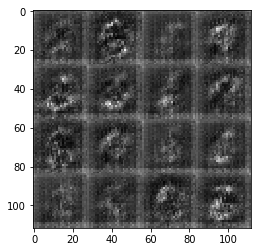

Epoch 0, batch 310: discriminator loss 0.4296, generator loss 1.5967
Epoch 0, batch 320: discriminator loss 1.1235, generator loss 0.5544
Epoch 0, batch 330: discriminator loss 0.4686, generator loss 2.0081
Epoch 0, batch 340: discriminator loss 0.8934, generator loss 0.8352
Epoch 0, batch 350: discriminator loss 0.5639, generator loss 1.3364
Epoch 0, batch 360: discriminator loss 0.8279, generator loss 2.0391
Epoch 0, batch 370: discriminator loss 0.7930, generator loss 1.7664
Epoch 0, batch 380: discriminator loss 1.0393, generator loss 2.9207
Epoch 0, batch 390: discriminator loss 1.5673, generator loss 0.2929
Epoch 0, batch 400: discriminator loss 0.6787, generator loss 1.1204


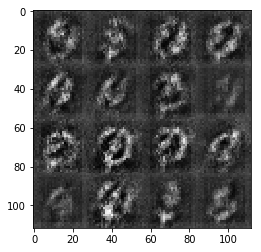

Epoch 0, batch 410: discriminator loss 1.0362, generator loss 0.6172
Epoch 0, batch 420: discriminator loss 0.6185, generator loss 1.8728
Epoch 0, batch 430: discriminator loss 0.6765, generator loss 2.0282
Epoch 0, batch 440: discriminator loss 0.6281, generator loss 1.4502
Epoch 0, batch 450: discriminator loss 0.9543, generator loss 1.1512
Epoch 0, batch 460: discriminator loss 0.8583, generator loss 2.5983
Epoch 0, batch 470: discriminator loss 0.7829, generator loss 0.9152
Epoch 0, batch 480: discriminator loss 0.9182, generator loss 2.2434
Epoch 0, batch 490: discriminator loss 0.2487, generator loss 2.8710
Epoch 0, batch 500: discriminator loss 0.0726, generator loss 5.7344


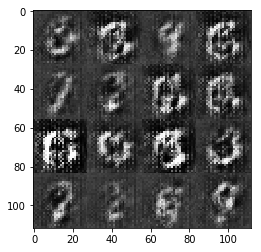

Epoch 0, batch 510: discriminator loss 0.4887, generator loss 1.9309
Epoch 0, batch 520: discriminator loss 0.5470, generator loss 2.6878
Epoch 0, batch 530: discriminator loss 0.3416, generator loss 1.6266
Epoch 0, batch 540: discriminator loss 0.7085, generator loss 1.3532
Epoch 0, batch 550: discriminator loss 0.9905, generator loss 1.9550
Epoch 0, batch 560: discriminator loss 0.3397, generator loss 3.7311
Epoch 0, batch 570: discriminator loss 0.4935, generator loss 1.4696
Epoch 0, batch 580: discriminator loss 0.9626, generator loss 0.6151
Epoch 0, batch 590: discriminator loss 0.6681, generator loss 1.9182
Epoch 0, batch 600: discriminator loss 0.5603, generator loss 1.2583


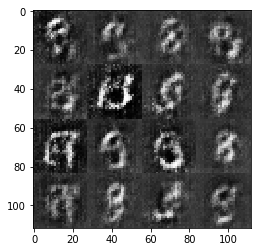

Epoch 0, batch 610: discriminator loss 0.5812, generator loss 2.0011
Epoch 0, batch 620: discriminator loss 0.4156, generator loss 1.5728
Epoch 0, batch 630: discriminator loss 0.3258, generator loss 1.5363
Epoch 0, batch 640: discriminator loss 1.1645, generator loss 3.0121
Epoch 0, batch 650: discriminator loss 0.3688, generator loss 1.7328
Epoch 0, batch 660: discriminator loss 0.5214, generator loss 1.9513
Epoch 0, batch 670: discriminator loss 1.0350, generator loss 0.7469
Epoch 0, batch 680: discriminator loss 0.5548, generator loss 1.2968
Epoch 0, batch 690: discriminator loss 0.8536, generator loss 2.8506
Epoch 0, batch 700: discriminator loss 0.2272, generator loss 2.2892


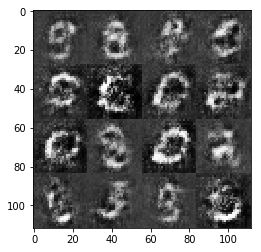

Epoch 0, batch 710: discriminator loss 0.6381, generator loss 3.8770
Epoch 0, batch 720: discriminator loss 0.5153, generator loss 1.6837
Epoch 0, batch 730: discriminator loss 0.2841, generator loss 3.6609
Epoch 0, batch 740: discriminator loss 0.1873, generator loss 2.7204
Epoch 0, batch 750: discriminator loss 0.3179, generator loss 2.0313
Epoch 0, batch 760: discriminator loss 0.3413, generator loss 3.6934
Epoch 0, batch 770: discriminator loss 0.7283, generator loss 0.9465
Epoch 0, batch 780: discriminator loss 0.3112, generator loss 3.7234
Epoch 0, batch 790: discriminator loss 0.5951, generator loss 1.3716
Epoch 0, batch 800: discriminator loss 0.3220, generator loss 2.5749


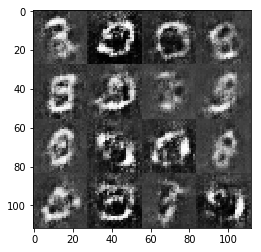

Epoch 0, batch 810: discriminator loss 0.3731, generator loss 1.4278
Epoch 0, batch 820: discriminator loss 0.9062, generator loss 3.4364
Epoch 0, batch 830: discriminator loss 0.3947, generator loss 2.4372
Epoch 0, batch 840: discriminator loss 0.5614, generator loss 1.0447
Epoch 0, batch 850: discriminator loss 1.0367, generator loss 4.0734
Epoch 0, batch 860: discriminator loss 1.0380, generator loss 4.0055
Epoch 0, batch 870: discriminator loss 0.3074, generator loss 2.0782
Epoch 0, batch 880: discriminator loss 0.5402, generator loss 1.3754
Epoch 0, batch 890: discriminator loss 0.7085, generator loss 1.2006
Epoch 0, batch 900: discriminator loss 0.3322, generator loss 5.5777


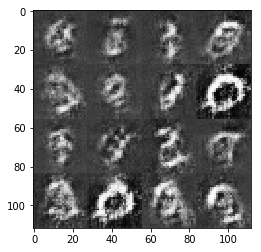

Epoch 0, batch 910: discriminator loss 0.5001, generator loss 1.9518
Epoch 0, batch 920: discriminator loss 0.3230, generator loss 2.3456
Epoch 0, batch 930: discriminator loss 0.4593, generator loss 1.3608
Epoch 0, batch 940: discriminator loss 0.9004, generator loss 2.9921
Epoch 0, batch 950: discriminator loss 0.4249, generator loss 1.9088
Epoch 0, batch 960: discriminator loss 0.6877, generator loss 2.8718
Epoch 0, batch 970: discriminator loss 0.4909, generator loss 2.9412
Epoch 0, batch 980: discriminator loss 0.2516, generator loss 2.9316
Epoch 0, batch 990: discriminator loss 0.2443, generator loss 4.5949
Epoch 0, batch 1000: discriminator loss 0.3156, generator loss 1.9594


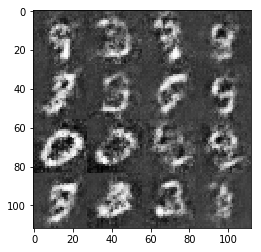

Epoch 0, batch 1010: discriminator loss 1.0232, generator loss 0.9287
Epoch 0, batch 1020: discriminator loss 0.9137, generator loss 0.9370
Epoch 0, batch 1030: discriminator loss 0.2257, generator loss 2.2673
Epoch 0, batch 1040: discriminator loss 0.6269, generator loss 1.1556
Epoch 0, batch 1050: discriminator loss 0.5509, generator loss 1.1202
Epoch 0, batch 1060: discriminator loss 0.5968, generator loss 3.1035
Epoch 0, batch 1070: discriminator loss 0.4377, generator loss 3.6391
Epoch 0, batch 1080: discriminator loss 0.3503, generator loss 1.6310
Epoch 0, batch 1090: discriminator loss 0.5356, generator loss 1.3834
Epoch 0, batch 1100: discriminator loss 0.3242, generator loss 2.0266


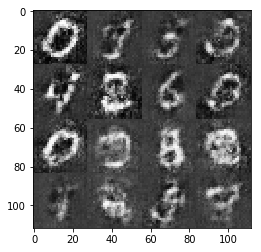

Epoch 0, batch 1110: discriminator loss 0.3324, generator loss 2.4751
Epoch 0, batch 1120: discriminator loss 0.7336, generator loss 1.1639
Epoch 0, batch 1130: discriminator loss 0.9198, generator loss 0.8288
Epoch 0, batch 1140: discriminator loss 0.1420, generator loss 4.3518
Epoch 0, batch 1150: discriminator loss 0.2454, generator loss 3.2035
Epoch 0, batch 1160: discriminator loss 0.2129, generator loss 2.0990
Epoch 0, batch 1170: discriminator loss 0.5622, generator loss 2.5464
Epoch 0, batch 1180: discriminator loss 0.4158, generator loss 2.6304
Epoch 0, batch 1190: discriminator loss 0.4211, generator loss 1.7974
Epoch 0, batch 1200: discriminator loss 0.4342, generator loss 2.8793


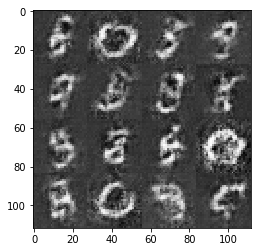

Epoch 0, batch 1210: discriminator loss 0.8740, generator loss 0.9643
Epoch 0, batch 1220: discriminator loss 0.4923, generator loss 3.0295
Epoch 0, batch 1230: discriminator loss 0.1935, generator loss 5.1337
Epoch 0, batch 1240: discriminator loss 0.2585, generator loss 2.1720
Epoch 0, batch 1250: discriminator loss 0.4090, generator loss 1.9649
Epoch 0, batch 1260: discriminator loss 0.5354, generator loss 1.4650
Epoch 0, batch 1270: discriminator loss 0.6336, generator loss 1.0461
Epoch 0, batch 1280: discriminator loss 0.4817, generator loss 1.4002
Epoch 0, batch 1290: discriminator loss 0.6475, generator loss 3.7024
Epoch 0, batch 1300: discriminator loss 0.3710, generator loss 3.6031


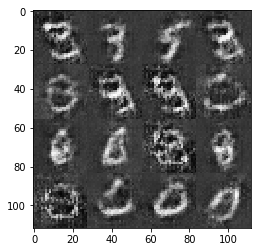

Epoch 0, batch 1310: discriminator loss 0.1890, generator loss 3.5014
Epoch 0, batch 1320: discriminator loss 0.5147, generator loss 2.1281
Epoch 0, batch 1330: discriminator loss 0.2643, generator loss 2.2700
Epoch 0, batch 1340: discriminator loss 0.2055, generator loss 3.1696
Epoch 0, batch 1350: discriminator loss 0.6757, generator loss 2.7451
Epoch 0, batch 1360: discriminator loss 0.3258, generator loss 2.5108
Epoch 0, batch 1370: discriminator loss 0.7670, generator loss 0.9598
Epoch 0, batch 1380: discriminator loss 0.9024, generator loss 1.1272
Epoch 0, batch 1390: discriminator loss 0.6609, generator loss 1.5521
Epoch 0, batch 1400: discriminator loss 0.2230, generator loss 2.6327


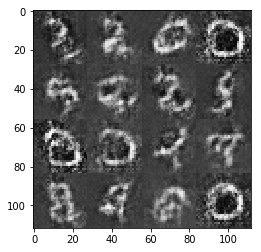

Epoch 0, batch 1410: discriminator loss 0.7390, generator loss 0.8268
Epoch 0, batch 1420: discriminator loss 0.7317, generator loss 0.9494
Epoch 0, batch 1430: discriminator loss 0.6918, generator loss 4.1871
Epoch 0, batch 1440: discriminator loss 0.9423, generator loss 0.9373
Epoch 0, batch 1450: discriminator loss 0.7289, generator loss 1.2669
Epoch 0, batch 1460: discriminator loss 0.5369, generator loss 1.6256
Epoch 0, batch 1470: discriminator loss 0.2930, generator loss 3.1316
Epoch 0, batch 1480: discriminator loss 0.3223, generator loss 2.3350
Epoch 0, batch 1490: discriminator loss 0.6492, generator loss 1.1203
Epoch 0, batch 1500: discriminator loss 0.2636, generator loss 2.9745


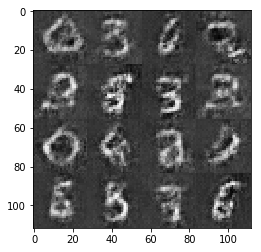

Epoch 0, batch 1510: discriminator loss 0.4588, generator loss 2.1317
Epoch 0, batch 1520: discriminator loss 0.1550, generator loss 3.2070
Epoch 0, batch 1530: discriminator loss 0.4365, generator loss 2.2447
Epoch 0, batch 1540: discriminator loss 1.0331, generator loss 1.3398
Epoch 0, batch 1550: discriminator loss 0.2539, generator loss 2.9735
Epoch 0, batch 1560: discriminator loss 0.3323, generator loss 1.8111
Epoch 0, batch 1570: discriminator loss 0.6586, generator loss 1.0440
Epoch 0, batch 1580: discriminator loss 0.3644, generator loss 1.7597
Epoch 0, batch 1590: discriminator loss 0.4596, generator loss 1.4896
Epoch 0, batch 1600: discriminator loss 1.2262, generator loss 2.6405


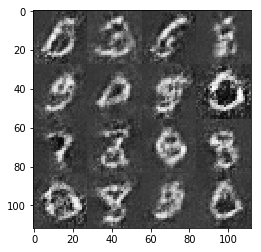

Epoch 0, batch 1610: discriminator loss 0.4665, generator loss 1.8804
Epoch 0, batch 1620: discriminator loss 0.3157, generator loss 1.9466
Epoch 0, batch 1630: discriminator loss 0.3684, generator loss 1.8849
Epoch 0, batch 1640: discriminator loss 0.3768, generator loss 2.0175
Epoch 0, batch 1650: discriminator loss 0.6320, generator loss 2.9728
Epoch 0, batch 1660: discriminator loss 0.9373, generator loss 1.9373
Epoch 0, batch 1670: discriminator loss 0.3556, generator loss 2.8429
Epoch 0, batch 1680: discriminator loss 1.2269, generator loss 0.8638
Epoch 0, batch 1690: discriminator loss 0.7323, generator loss 1.1789
Epoch 0, batch 1700: discriminator loss 0.6752, generator loss 1.0814


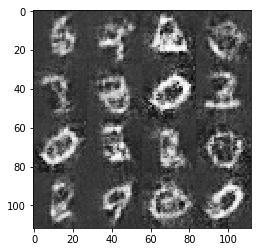

Epoch 0, batch 1710: discriminator loss 0.4913, generator loss 2.0001
Epoch 0, batch 1720: discriminator loss 0.2126, generator loss 2.3422
Epoch 0, batch 1730: discriminator loss 0.7223, generator loss 1.2538
Epoch 0, batch 1740: discriminator loss 0.9284, generator loss 0.8210
Epoch 0, batch 1750: discriminator loss 0.3498, generator loss 2.1459
Epoch 0, batch 1760: discriminator loss 0.5030, generator loss 1.6149
Epoch 0, batch 1770: discriminator loss 0.4251, generator loss 2.7056
Epoch 0, batch 1780: discriminator loss 0.2486, generator loss 2.4755
Epoch 0, batch 1790: discriminator loss 1.0719, generator loss 5.1662
Epoch 0, batch 1800: discriminator loss 0.5473, generator loss 1.2040


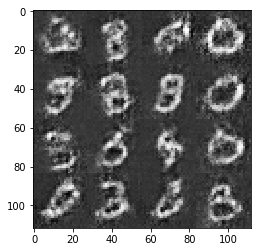

Epoch 0, batch 1810: discriminator loss 0.3464, generator loss 1.9550
Epoch 0, batch 1820: discriminator loss 0.3111, generator loss 2.4251
Epoch 0, batch 1830: discriminator loss 0.5786, generator loss 1.4011
Epoch 0, batch 1840: discriminator loss 0.5670, generator loss 1.5743
Epoch 0, batch 1850: discriminator loss 0.4188, generator loss 2.5892
Epoch 0, batch 1860: discriminator loss 0.2846, generator loss 2.6945
Epoch 0, batch 1870: discriminator loss 0.3927, generator loss 2.4161
Epoch 0, batch 1880: discriminator loss 0.6097, generator loss 2.0763
Epoch 0, batch 1890: discriminator loss 0.3927, generator loss 2.5299
Epoch 0, batch 1900: discriminator loss 0.5531, generator loss 1.3125


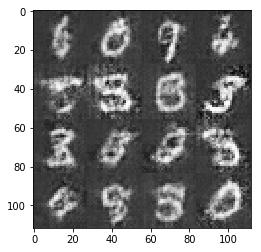

Epoch 0, batch 1910: discriminator loss 0.4158, generator loss 2.9689
Epoch 0, batch 1920: discriminator loss 0.3463, generator loss 1.9429
Epoch 0, batch 1930: discriminator loss 0.7504, generator loss 2.8746
Epoch 0, batch 1940: discriminator loss 0.2582, generator loss 2.8019
Epoch 0, batch 1950: discriminator loss 0.4913, generator loss 1.3058
Epoch 0, batch 1960: discriminator loss 0.6711, generator loss 3.4009
Epoch 0, batch 1970: discriminator loss 0.1984, generator loss 2.4948
Epoch 0, batch 1980: discriminator loss 0.3776, generator loss 2.0191
Epoch 0, batch 1990: discriminator loss 0.4896, generator loss 1.6104
Epoch 0, batch 2000: discriminator loss 0.3437, generator loss 1.7139


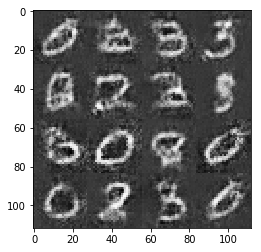

Epoch 0, batch 2010: discriminator loss 0.4440, generator loss 1.6207
Epoch 0, batch 2020: discriminator loss 0.7017, generator loss 1.1309
Epoch 0, batch 2030: discriminator loss 0.4859, generator loss 2.5902
Epoch 0, batch 2040: discriminator loss 0.4236, generator loss 2.4048
Epoch 0, batch 2050: discriminator loss 0.4137, generator loss 1.6234
Epoch 0, batch 2060: discriminator loss 0.1860, generator loss 3.8746
Epoch 0, batch 2070: discriminator loss 0.2994, generator loss 2.2710
Epoch 0, batch 2080: discriminator loss 1.8666, generator loss 0.2888
Epoch 0, batch 2090: discriminator loss 1.5026, generator loss 0.8480
Epoch 0, batch 2100: discriminator loss 0.2753, generator loss 2.1815


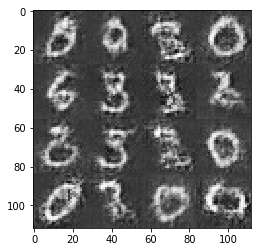

Epoch 0, batch 2110: discriminator loss 0.6316, generator loss 1.1637
Epoch 0, batch 2120: discriminator loss 0.2078, generator loss 2.7914
Epoch 0, batch 2130: discriminator loss 0.2078, generator loss 2.5217
Epoch 0, batch 2140: discriminator loss 0.5170, generator loss 1.2959
Epoch 0, batch 2150: discriminator loss 0.2260, generator loss 3.4296
Epoch 0, batch 2160: discriminator loss 0.1907, generator loss 3.6038
Epoch 0, batch 2170: discriminator loss 0.2246, generator loss 2.1678
Epoch 0, batch 2180: discriminator loss 0.4227, generator loss 1.6910
Epoch 0, batch 2190: discriminator loss 0.1722, generator loss 4.0643
Epoch 0, batch 2200: discriminator loss 0.3085, generator loss 1.9830


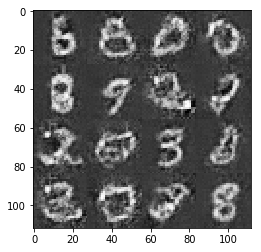

Epoch 0, batch 2210: discriminator loss 0.6079, generator loss 2.1835
Epoch 0, batch 2220: discriminator loss 0.3662, generator loss 1.9114
Epoch 0, batch 2230: discriminator loss 1.4373, generator loss 0.6230
Epoch 0, batch 2240: discriminator loss 0.4150, generator loss 2.2049
Epoch 0, batch 2250: discriminator loss 0.6499, generator loss 1.3036
Epoch 0, batch 2260: discriminator loss 0.5507, generator loss 1.4651
Epoch 0, batch 2270: discriminator loss 0.5325, generator loss 2.5993
Epoch 0, batch 2280: discriminator loss 0.4805, generator loss 1.4069
Epoch 0, batch 2290: discriminator loss 0.5274, generator loss 1.5537
Epoch 0, batch 2300: discriminator loss 0.2223, generator loss 3.2159


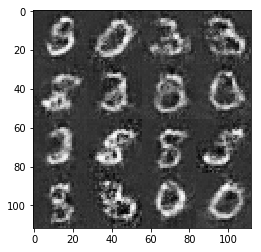

Epoch 0, batch 2310: discriminator loss 0.7632, generator loss 2.3015
Epoch 0, batch 2320: discriminator loss 0.3716, generator loss 1.9805
Epoch 0, batch 2330: discriminator loss 0.8199, generator loss 1.0529
Epoch 0, batch 2340: discriminator loss 0.4544, generator loss 1.8329
Epoch 0, batch 2350: discriminator loss 0.6144, generator loss 2.4296
Epoch 0, batch 2360: discriminator loss 0.3067, generator loss 2.4362
Epoch 0, batch 2370: discriminator loss 0.4984, generator loss 1.9087
Epoch 0, batch 2380: discriminator loss 0.4472, generator loss 1.8726
Epoch 0, batch 2390: discriminator loss 0.8233, generator loss 1.0457
Epoch 0, batch 2400: discriminator loss 0.5044, generator loss 1.4251


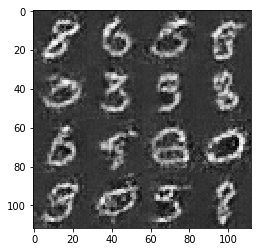

Epoch 0, batch 2410: discriminator loss 0.5951, generator loss 1.0544
Epoch 0, batch 2420: discriminator loss 0.6539, generator loss 1.1633
Epoch 0, batch 2430: discriminator loss 0.3482, generator loss 2.6134
Epoch 0, batch 2440: discriminator loss 0.5860, generator loss 2.0569
Epoch 0, batch 2450: discriminator loss 0.6660, generator loss 2.1615
Epoch 0, batch 2460: discriminator loss 0.6728, generator loss 0.9932
Epoch 0, batch 2470: discriminator loss 0.6429, generator loss 1.4110
Epoch 0, batch 2480: discriminator loss 0.6826, generator loss 2.1466
Epoch 0, batch 2490: discriminator loss 1.0503, generator loss 0.9868
Epoch 0, batch 2500: discriminator loss 0.3906, generator loss 2.1030


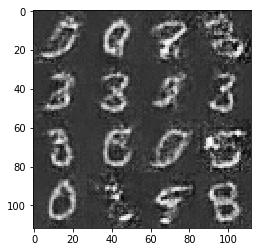

Epoch 0, batch 2510: discriminator loss 0.4482, generator loss 1.9466
Epoch 0, batch 2520: discriminator loss 0.4272, generator loss 1.7995
Epoch 0, batch 2530: discriminator loss 0.5885, generator loss 1.9255
Epoch 0, batch 2540: discriminator loss 0.8561, generator loss 1.1581
Epoch 0, batch 2550: discriminator loss 0.4700, generator loss 3.2843
Epoch 0, batch 2560: discriminator loss 0.6336, generator loss 1.1966
Epoch 0, batch 2570: discriminator loss 0.4054, generator loss 2.5035
Epoch 0, batch 2580: discriminator loss 1.0337, generator loss 0.7080
Epoch 0, batch 2590: discriminator loss 0.5395, generator loss 1.8895
Epoch 0, batch 2600: discriminator loss 1.1788, generator loss 0.8325


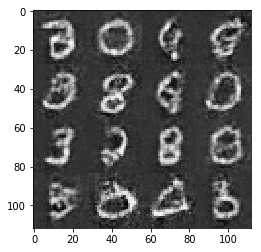

Epoch 0, batch 2610: discriminator loss 0.5567, generator loss 1.4075
Epoch 0, batch 2620: discriminator loss 0.7330, generator loss 1.3131
Epoch 0, batch 2630: discriminator loss 0.4714, generator loss 1.5240
Epoch 0, batch 2640: discriminator loss 1.1139, generator loss 0.7229
Epoch 0, batch 2650: discriminator loss 0.4628, generator loss 2.0819
Epoch 0, batch 2660: discriminator loss 0.5270, generator loss 1.4659
Epoch 0, batch 2670: discriminator loss 0.5437, generator loss 1.4524
Epoch 0, batch 2680: discriminator loss 0.6966, generator loss 1.1484
Epoch 0, batch 2690: discriminator loss 0.7810, generator loss 1.0952
Epoch 0, batch 2700: discriminator loss 0.5775, generator loss 1.4023


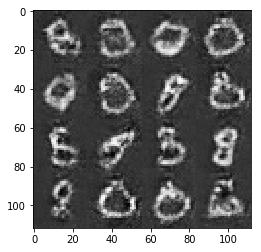

Epoch 0, batch 2710: discriminator loss 0.5292, generator loss 1.8700
Epoch 0, batch 2720: discriminator loss 0.7099, generator loss 1.4340
Epoch 0, batch 2730: discriminator loss 0.4520, generator loss 2.4984
Epoch 0, batch 2740: discriminator loss 0.4401, generator loss 1.7286
Epoch 0, batch 2750: discriminator loss 0.6190, generator loss 2.8781
Epoch 0, batch 2760: discriminator loss 0.4626, generator loss 1.8328
Epoch 0, batch 2770: discriminator loss 0.3963, generator loss 1.5874
Epoch 0, batch 2780: discriminator loss 0.3163, generator loss 2.3178
Epoch 0, batch 2790: discriminator loss 0.5826, generator loss 2.6566
Epoch 0, batch 2800: discriminator loss 0.9349, generator loss 0.7955


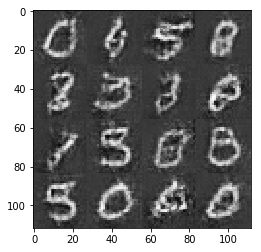

Epoch 0, batch 2810: discriminator loss 0.3808, generator loss 1.7921
Epoch 0, batch 2820: discriminator loss 0.6675, generator loss 1.2828
Epoch 0, batch 2830: discriminator loss 0.9464, generator loss 1.0457
Epoch 0, batch 2840: discriminator loss 0.4109, generator loss 2.4894
Epoch 0, batch 2850: discriminator loss 0.6102, generator loss 2.2507
Epoch 0, batch 2860: discriminator loss 0.5173, generator loss 2.0321
Epoch 0, batch 2870: discriminator loss 0.4012, generator loss 1.9550
Epoch 0, batch 2880: discriminator loss 0.6905, generator loss 1.4893
Epoch 0, batch 2890: discriminator loss 0.7134, generator loss 3.7184
Epoch 0, batch 2900: discriminator loss 0.5795, generator loss 2.8495


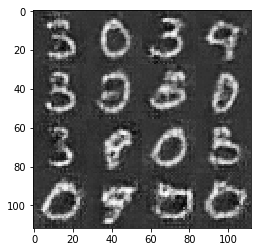

Epoch 0, batch 2910: discriminator loss 1.1442, generator loss 0.5583
Epoch 0, batch 2920: discriminator loss 0.5318, generator loss 1.7440
Epoch 0, batch 2930: discriminator loss 0.6538, generator loss 2.8395
Epoch 0, batch 2940: discriminator loss 0.7992, generator loss 0.9136
Epoch 0, batch 2950: discriminator loss 0.5939, generator loss 2.1203
Epoch 0, batch 2960: discriminator loss 0.5943, generator loss 2.4157
Epoch 0, batch 2970: discriminator loss 0.4229, generator loss 4.7624
Epoch 0, batch 2980: discriminator loss 0.6534, generator loss 1.4207
Epoch 0, batch 2990: discriminator loss 1.1522, generator loss 1.8981
Epoch 0, batch 3000: discriminator loss 0.6780, generator loss 1.5227


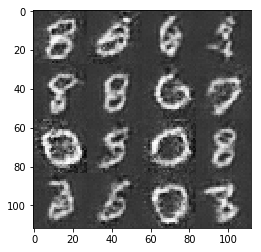

Epoch 0, batch 3010: discriminator loss 0.7390, generator loss 1.0430
Epoch 0, batch 3020: discriminator loss 0.6424, generator loss 1.1374
Epoch 0, batch 3030: discriminator loss 0.6855, generator loss 1.2660
Epoch 0, batch 3040: discriminator loss 0.4179, generator loss 1.3757
Epoch 0, batch 3050: discriminator loss 0.6438, generator loss 1.2432
Epoch 0, batch 3060: discriminator loss 0.4543, generator loss 2.2959
Epoch 0, batch 3070: discriminator loss 0.7508, generator loss 1.8357
Epoch 0, batch 3080: discriminator loss 0.5296, generator loss 1.2982
Epoch 0, batch 3090: discriminator loss 0.8387, generator loss 0.9908
Epoch 0, batch 3100: discriminator loss 0.6656, generator loss 1.3588


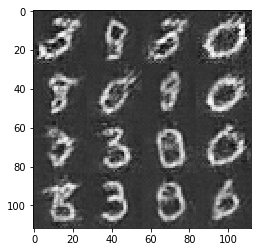

Epoch 0, batch 3110: discriminator loss 0.5190, generator loss 2.4189
Epoch 0, batch 3120: discriminator loss 0.9661, generator loss 1.4091
Epoch 0, batch 3130: discriminator loss 0.6912, generator loss 0.9971
Epoch 0, batch 3140: discriminator loss 0.5187, generator loss 1.4806
Epoch 0, batch 3150: discriminator loss 0.5581, generator loss 1.6549
Epoch 0, batch 3160: discriminator loss 0.3429, generator loss 2.2601
Epoch 0, batch 3170: discriminator loss 0.5709, generator loss 1.7167
Epoch 0, batch 3180: discriminator loss 0.7456, generator loss 2.4430
Epoch 0, batch 3190: discriminator loss 0.5275, generator loss 2.6518
Epoch 0, batch 3200: discriminator loss 1.0050, generator loss 0.7792


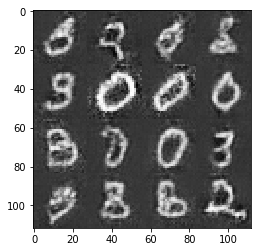

Epoch 0, batch 3210: discriminator loss 0.4826, generator loss 1.5134
Epoch 0, batch 3220: discriminator loss 0.5864, generator loss 1.9454
Epoch 0, batch 3230: discriminator loss 0.4270, generator loss 2.4238
Epoch 0, batch 3240: discriminator loss 0.6076, generator loss 2.5502
Epoch 0, batch 3250: discriminator loss 0.3161, generator loss 2.2781
Epoch 0, batch 3260: discriminator loss 0.5847, generator loss 1.3952
Epoch 0, batch 3270: discriminator loss 0.4761, generator loss 1.8379
Epoch 0, batch 3280: discriminator loss 0.4700, generator loss 1.3693
Epoch 0, batch 3290: discriminator loss 0.4199, generator loss 2.7567
Epoch 0, batch 3300: discriminator loss 0.4585, generator loss 2.4063


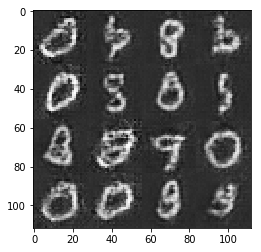

Epoch 0, batch 3310: discriminator loss 0.6379, generator loss 1.4605
Epoch 0, batch 3320: discriminator loss 1.0104, generator loss 0.7134
Epoch 0, batch 3330: discriminator loss 0.4370, generator loss 1.5881
Epoch 0, batch 3340: discriminator loss 0.7271, generator loss 1.0378
Epoch 0, batch 3350: discriminator loss 0.5829, generator loss 1.5598
Epoch 0, batch 3360: discriminator loss 0.6108, generator loss 1.2713
Epoch 0, batch 3370: discriminator loss 0.4807, generator loss 1.3723
Epoch 0, batch 3380: discriminator loss 0.7419, generator loss 1.7908
Epoch 0, batch 3390: discriminator loss 0.7121, generator loss 2.5117
Epoch 0, batch 3400: discriminator loss 0.4506, generator loss 2.2102


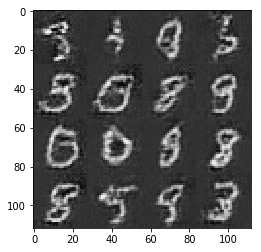

Epoch 0, batch 3410: discriminator loss 0.4489, generator loss 2.1954
Epoch 0, batch 3420: discriminator loss 0.6202, generator loss 1.8110
Epoch 0, batch 3430: discriminator loss 0.4030, generator loss 2.4356
Epoch 0, batch 3440: discriminator loss 0.3331, generator loss 2.1938
Epoch 0, batch 3450: discriminator loss 0.7041, generator loss 1.5405
Epoch 0, batch 3460: discriminator loss 0.6350, generator loss 2.1183
Epoch 0, batch 3470: discriminator loss 0.3133, generator loss 2.2865
Epoch 0, batch 3480: discriminator loss 0.4569, generator loss 1.8192
Epoch 0, batch 3490: discriminator loss 0.5611, generator loss 1.6048
Epoch 0, batch 3500: discriminator loss 0.7800, generator loss 0.9507


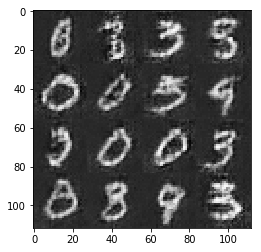

Epoch 0, batch 3510: discriminator loss 0.5062, generator loss 1.7311
Epoch 0, batch 3520: discriminator loss 0.7255, generator loss 0.9362
Epoch 0, batch 3530: discriminator loss 1.1106, generator loss 1.0273
Epoch 0, batch 3540: discriminator loss 0.6529, generator loss 1.0827
Epoch 0, batch 3550: discriminator loss 0.5666, generator loss 1.5499
Epoch 0, batch 3560: discriminator loss 0.6123, generator loss 2.0045
Epoch 0, batch 3570: discriminator loss 0.7900, generator loss 0.9313
Epoch 0, batch 3580: discriminator loss 1.0187, generator loss 0.8152
Epoch 0, batch 3590: discriminator loss 0.7385, generator loss 1.0962
Epoch 0, batch 3600: discriminator loss 0.6200, generator loss 1.7443


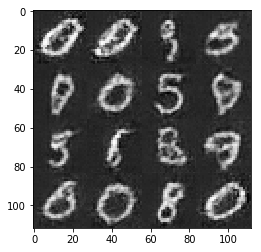

Epoch 0, batch 3610: discriminator loss 0.6575, generator loss 1.6152
Epoch 0, batch 3620: discriminator loss 0.6191, generator loss 2.5286
Epoch 0, batch 3630: discriminator loss 0.7439, generator loss 1.6174
Epoch 0, batch 3640: discriminator loss 0.6187, generator loss 1.8682
Epoch 0, batch 3650: discriminator loss 0.5634, generator loss 1.4848
Epoch 0, batch 3660: discriminator loss 0.6959, generator loss 2.3958
Epoch 0, batch 3670: discriminator loss 0.5662, generator loss 1.3699
Epoch 0, batch 3680: discriminator loss 0.5809, generator loss 1.2229
Epoch 0, batch 3690: discriminator loss 0.5072, generator loss 2.7238
Epoch 0, batch 3700: discriminator loss 0.6442, generator loss 2.0972


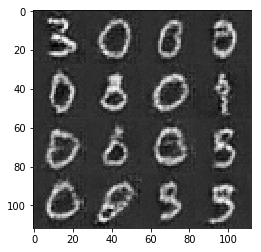

Epoch 0, batch 3710: discriminator loss 0.7894, generator loss 0.9722
Epoch 0, batch 3720: discriminator loss 0.6644, generator loss 1.2954
Epoch 0, batch 3730: discriminator loss 0.4905, generator loss 2.8386
Epoch 0, batch 3740: discriminator loss 0.7898, generator loss 1.0828
Epoch 0, batch 3750: discriminator loss 0.3961, generator loss 2.3733
Epoch 1, batch 3760: discriminator loss 0.4888, generator loss 1.6526
Epoch 1, batch 3770: discriminator loss 0.7765, generator loss 1.5690
Epoch 1, batch 3780: discriminator loss 0.9201, generator loss 1.0722
Epoch 1, batch 3790: discriminator loss 1.2406, generator loss 0.6291
Epoch 1, batch 3800: discriminator loss 0.3633, generator loss 2.2287


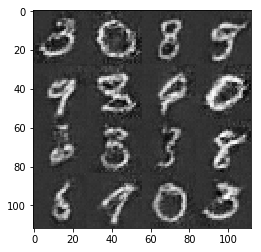

Epoch 1, batch 3810: discriminator loss 0.5053, generator loss 1.4981
Epoch 1, batch 3820: discriminator loss 0.5400, generator loss 1.9016
Epoch 1, batch 3830: discriminator loss 0.3198, generator loss 2.0435
Epoch 1, batch 3840: discriminator loss 0.7993, generator loss 1.0039
Epoch 1, batch 3850: discriminator loss 0.7730, generator loss 1.6289
Epoch 1, batch 3860: discriminator loss 1.2608, generator loss 0.6178
Epoch 1, batch 3870: discriminator loss 1.1243, generator loss 0.5754
Epoch 1, batch 3880: discriminator loss 0.6590, generator loss 2.4300
Epoch 1, batch 3890: discriminator loss 1.0015, generator loss 0.6887
Epoch 1, batch 3900: discriminator loss 0.7529, generator loss 0.9872


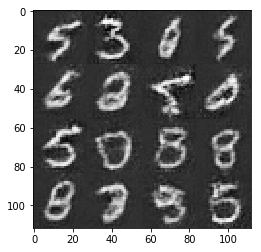

Epoch 1, batch 3910: discriminator loss 0.4762, generator loss 1.5143
Epoch 1, batch 3920: discriminator loss 0.7150, generator loss 1.2264
Epoch 1, batch 3930: discriminator loss 0.6707, generator loss 1.2629
Epoch 1, batch 3940: discriminator loss 0.7112, generator loss 1.0440
Epoch 1, batch 3950: discriminator loss 0.5419, generator loss 1.8555
Epoch 1, batch 3960: discriminator loss 0.5017, generator loss 1.5857
Epoch 1, batch 3970: discriminator loss 0.3608, generator loss 1.7391
Epoch 1, batch 3980: discriminator loss 0.4022, generator loss 2.1550
Epoch 1, batch 3990: discriminator loss 0.5094, generator loss 1.9076
Epoch 1, batch 4000: discriminator loss 0.7625, generator loss 1.2287


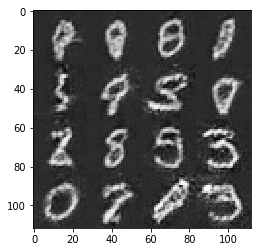

Epoch 1, batch 4010: discriminator loss 0.8871, generator loss 0.8679
Epoch 1, batch 4020: discriminator loss 0.9754, generator loss 2.1738
Epoch 1, batch 4030: discriminator loss 0.8614, generator loss 1.0270
Epoch 1, batch 4040: discriminator loss 0.6679, generator loss 1.0784
Epoch 1, batch 4050: discriminator loss 0.5843, generator loss 1.9294
Epoch 1, batch 4060: discriminator loss 0.7276, generator loss 2.2254
Epoch 1, batch 4070: discriminator loss 0.5529, generator loss 1.2853
Epoch 1, batch 4080: discriminator loss 0.5738, generator loss 1.2336
Epoch 1, batch 4090: discriminator loss 0.6987, generator loss 2.3992
Epoch 1, batch 4100: discriminator loss 0.5635, generator loss 1.3991


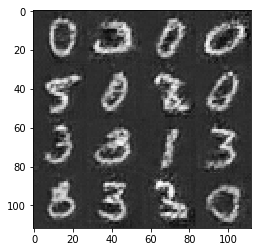

Epoch 1, batch 4110: discriminator loss 0.5619, generator loss 1.5028
Epoch 1, batch 4120: discriminator loss 0.8330, generator loss 0.8622
Epoch 1, batch 4130: discriminator loss 0.6000, generator loss 1.6420
Epoch 1, batch 4140: discriminator loss 0.5462, generator loss 2.8402
Epoch 1, batch 4150: discriminator loss 0.8094, generator loss 2.3560
Epoch 1, batch 4160: discriminator loss 0.5067, generator loss 1.8893
Epoch 1, batch 4170: discriminator loss 0.9407, generator loss 0.7087
Epoch 1, batch 4180: discriminator loss 0.6627, generator loss 1.7342
Epoch 1, batch 4190: discriminator loss 0.5569, generator loss 1.9248
Epoch 1, batch 4200: discriminator loss 0.8077, generator loss 2.7157


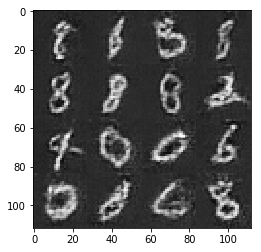

Epoch 1, batch 4210: discriminator loss 0.7044, generator loss 1.1610
Epoch 1, batch 4220: discriminator loss 0.8758, generator loss 1.0646
Epoch 1, batch 4230: discriminator loss 0.8403, generator loss 1.2145
Epoch 1, batch 4240: discriminator loss 0.8914, generator loss 0.9066
Epoch 1, batch 4250: discriminator loss 0.7987, generator loss 2.7313
Epoch 1, batch 4260: discriminator loss 0.6540, generator loss 1.6488
Epoch 1, batch 4270: discriminator loss 0.8300, generator loss 0.9052
Epoch 1, batch 4280: discriminator loss 0.5262, generator loss 1.3069
Epoch 1, batch 4290: discriminator loss 0.6023, generator loss 1.6914
Epoch 1, batch 4300: discriminator loss 0.6454, generator loss 1.1613


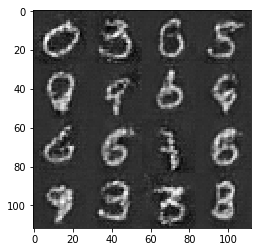

Epoch 1, batch 4310: discriminator loss 0.3418, generator loss 2.2003
Epoch 1, batch 4320: discriminator loss 0.3703, generator loss 2.1951
Epoch 1, batch 4330: discriminator loss 1.4925, generator loss 0.4605
Epoch 1, batch 4340: discriminator loss 0.4647, generator loss 1.4028
Epoch 1, batch 4350: discriminator loss 0.7748, generator loss 1.2925
Epoch 1, batch 4360: discriminator loss 0.6050, generator loss 1.5815
Epoch 1, batch 4370: discriminator loss 0.6418, generator loss 1.3839
Epoch 1, batch 4380: discriminator loss 0.4071, generator loss 2.3005
Epoch 1, batch 4390: discriminator loss 1.6266, generator loss 0.5229
Epoch 1, batch 4400: discriminator loss 0.4570, generator loss 1.7925


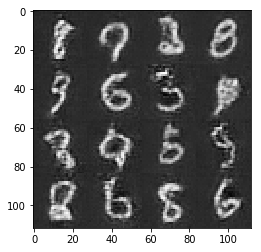

Epoch 1, batch 4410: discriminator loss 0.5001, generator loss 1.6797
Epoch 1, batch 4420: discriminator loss 0.6951, generator loss 2.0602
Epoch 1, batch 4430: discriminator loss 0.4536, generator loss 1.6245
Epoch 1, batch 4440: discriminator loss 0.5825, generator loss 1.7814
Epoch 1, batch 4450: discriminator loss 0.5538, generator loss 1.2987
Epoch 1, batch 4460: discriminator loss 0.6582, generator loss 1.2526
Epoch 1, batch 4470: discriminator loss 0.6369, generator loss 1.6016
Epoch 1, batch 4480: discriminator loss 0.5449, generator loss 1.1917
Epoch 1, batch 4490: discriminator loss 1.2991, generator loss 0.6822
Epoch 1, batch 4500: discriminator loss 0.7675, generator loss 1.7255


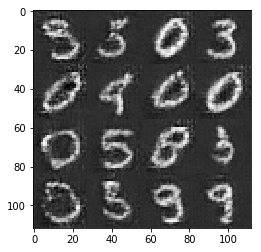

Epoch 1, batch 4510: discriminator loss 0.5797, generator loss 1.5453
Epoch 1, batch 4520: discriminator loss 0.4877, generator loss 1.6212
Epoch 1, batch 4530: discriminator loss 0.7339, generator loss 1.4814
Epoch 1, batch 4540: discriminator loss 0.5250, generator loss 1.5567
Epoch 1, batch 4550: discriminator loss 0.8098, generator loss 0.9632
Epoch 1, batch 4560: discriminator loss 0.6532, generator loss 2.1907
Epoch 1, batch 4570: discriminator loss 0.4061, generator loss 1.8640
Epoch 1, batch 4580: discriminator loss 0.6110, generator loss 1.5354
Epoch 1, batch 4590: discriminator loss 0.4059, generator loss 2.1284
Epoch 1, batch 4600: discriminator loss 0.6128, generator loss 2.1679


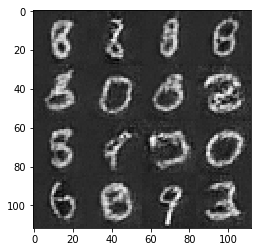

Epoch 1, batch 4610: discriminator loss 0.6339, generator loss 1.5071
Epoch 1, batch 4620: discriminator loss 0.6186, generator loss 1.3693
Epoch 1, batch 4630: discriminator loss 0.9323, generator loss 0.7534
Epoch 1, batch 4640: discriminator loss 0.3604, generator loss 1.9558
Epoch 1, batch 4650: discriminator loss 0.5760, generator loss 1.7484
Epoch 1, batch 4660: discriminator loss 0.6277, generator loss 1.3572
Epoch 1, batch 4670: discriminator loss 0.4321, generator loss 2.0153
Epoch 1, batch 4680: discriminator loss 0.7953, generator loss 1.8300
Epoch 1, batch 4690: discriminator loss 0.7684, generator loss 1.0586
Epoch 1, batch 4700: discriminator loss 1.0654, generator loss 0.7258


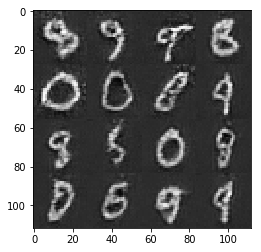

Epoch 1, batch 4710: discriminator loss 1.1312, generator loss 2.9338
Epoch 1, batch 4720: discriminator loss 0.6739, generator loss 2.4763
Epoch 1, batch 4730: discriminator loss 0.6109, generator loss 1.5296
Epoch 1, batch 4740: discriminator loss 0.5207, generator loss 1.5776
Epoch 1, batch 4750: discriminator loss 0.9277, generator loss 0.9867
Epoch 1, batch 4760: discriminator loss 0.9131, generator loss 1.2833
Epoch 1, batch 4770: discriminator loss 0.7627, generator loss 1.0608
Epoch 1, batch 4780: discriminator loss 1.0355, generator loss 0.9600
Epoch 1, batch 4790: discriminator loss 0.6615, generator loss 2.2504
Epoch 1, batch 4800: discriminator loss 0.5193, generator loss 1.5680


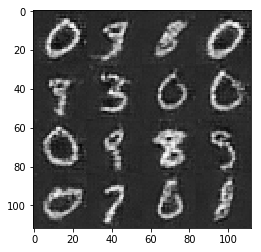

Epoch 1, batch 4810: discriminator loss 0.6555, generator loss 1.6946
Epoch 1, batch 4820: discriminator loss 0.5620, generator loss 1.3682
Epoch 1, batch 4830: discriminator loss 0.5500, generator loss 1.2729
Epoch 1, batch 4840: discriminator loss 0.7681, generator loss 0.9974
Epoch 1, batch 4850: discriminator loss 0.4853, generator loss 1.9924
Epoch 1, batch 4860: discriminator loss 0.8948, generator loss 1.0946
Epoch 1, batch 4870: discriminator loss 0.4460, generator loss 1.7522
Epoch 1, batch 4880: discriminator loss 0.7106, generator loss 1.0963
Epoch 1, batch 4890: discriminator loss 0.6352, generator loss 1.2352
Epoch 1, batch 4900: discriminator loss 1.0452, generator loss 0.7928


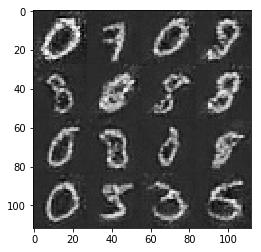

Epoch 1, batch 4910: discriminator loss 0.6519, generator loss 2.0733
Epoch 1, batch 4920: discriminator loss 0.7986, generator loss 1.8506
Epoch 1, batch 4930: discriminator loss 0.5605, generator loss 1.5552
Epoch 1, batch 4940: discriminator loss 0.6524, generator loss 1.2011
Epoch 1, batch 4950: discriminator loss 0.5172, generator loss 1.5185
Epoch 1, batch 4960: discriminator loss 0.6224, generator loss 1.8054
Epoch 1, batch 4970: discriminator loss 0.5912, generator loss 1.4465
Epoch 1, batch 4980: discriminator loss 0.5653, generator loss 1.8052
Epoch 1, batch 4990: discriminator loss 0.6275, generator loss 1.2886
Epoch 1, batch 5000: discriminator loss 0.8819, generator loss 0.9525


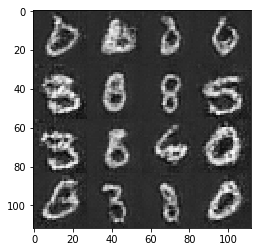

Epoch 1, batch 5010: discriminator loss 0.4919, generator loss 2.1348
Epoch 1, batch 5020: discriminator loss 0.6786, generator loss 1.2021
Epoch 1, batch 5030: discriminator loss 0.6356, generator loss 1.3964
Epoch 1, batch 5040: discriminator loss 0.4480, generator loss 1.5288
Epoch 1, batch 5050: discriminator loss 0.5467, generator loss 1.4483
Epoch 1, batch 5060: discriminator loss 0.7477, generator loss 0.9102
Epoch 1, batch 5070: discriminator loss 0.8839, generator loss 0.7735
Epoch 1, batch 5080: discriminator loss 0.6778, generator loss 1.2811
Epoch 1, batch 5090: discriminator loss 0.6386, generator loss 1.1618
Epoch 1, batch 5100: discriminator loss 0.4714, generator loss 1.9379


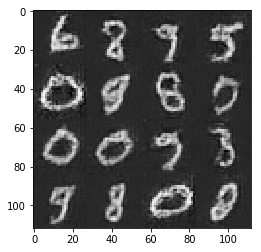

Epoch 1, batch 5110: discriminator loss 0.9413, generator loss 0.8567
Epoch 1, batch 5120: discriminator loss 0.8014, generator loss 1.1735
Epoch 1, batch 5130: discriminator loss 1.3294, generator loss 0.4363
Epoch 1, batch 5140: discriminator loss 0.6807, generator loss 1.3912
Epoch 1, batch 5150: discriminator loss 0.4033, generator loss 2.5793
Epoch 1, batch 5160: discriminator loss 0.5381, generator loss 2.0343
Epoch 1, batch 5170: discriminator loss 0.8750, generator loss 0.8364
Epoch 1, batch 5180: discriminator loss 0.6455, generator loss 1.6000
Epoch 1, batch 5190: discriminator loss 0.3868, generator loss 1.8408
Epoch 1, batch 5200: discriminator loss 1.0984, generator loss 0.8120


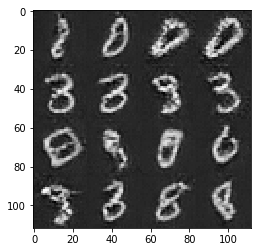

Epoch 1, batch 5210: discriminator loss 0.4932, generator loss 2.0175
Epoch 1, batch 5220: discriminator loss 0.5573, generator loss 1.5352
Epoch 1, batch 5230: discriminator loss 0.8614, generator loss 0.9244
Epoch 1, batch 5240: discriminator loss 1.2194, generator loss 0.4718
Epoch 1, batch 5250: discriminator loss 0.6477, generator loss 2.2899
Epoch 1, batch 5260: discriminator loss 0.4810, generator loss 2.0804
Epoch 1, batch 5270: discriminator loss 1.0295, generator loss 0.9337
Epoch 1, batch 5280: discriminator loss 0.6171, generator loss 1.6756
Epoch 1, batch 5290: discriminator loss 0.6549, generator loss 1.4471
Epoch 1, batch 5300: discriminator loss 0.7433, generator loss 2.0710


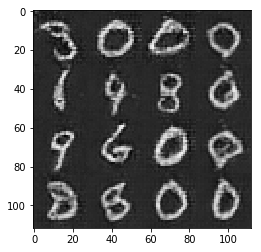

Epoch 1, batch 5310: discriminator loss 0.9391, generator loss 0.8755
Epoch 1, batch 5320: discriminator loss 1.0427, generator loss 1.0668
Epoch 1, batch 5330: discriminator loss 0.6405, generator loss 1.2569
Epoch 1, batch 5340: discriminator loss 0.9686, generator loss 1.0157
Epoch 1, batch 5350: discriminator loss 1.0549, generator loss 0.8032
Epoch 1, batch 5360: discriminator loss 0.5302, generator loss 1.4872
Epoch 1, batch 5370: discriminator loss 0.3489, generator loss 2.1481
Epoch 1, batch 5380: discriminator loss 0.6989, generator loss 1.4145
Epoch 1, batch 5390: discriminator loss 0.6528, generator loss 1.2747
Epoch 1, batch 5400: discriminator loss 0.6435, generator loss 1.7213


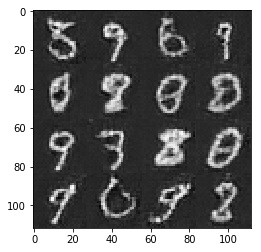

Epoch 1, batch 5410: discriminator loss 0.7390, generator loss 1.0649
Epoch 1, batch 5420: discriminator loss 0.5865, generator loss 1.2923
Epoch 1, batch 5430: discriminator loss 0.5144, generator loss 1.4902
Epoch 1, batch 5440: discriminator loss 0.5791, generator loss 1.6965
Epoch 1, batch 5450: discriminator loss 0.5082, generator loss 1.6476
Epoch 1, batch 5460: discriminator loss 0.6331, generator loss 1.3949
Epoch 1, batch 5470: discriminator loss 0.8776, generator loss 0.6913
Epoch 1, batch 5480: discriminator loss 0.6115, generator loss 1.8696
Epoch 1, batch 5490: discriminator loss 0.8633, generator loss 0.7999
Epoch 1, batch 5500: discriminator loss 0.7403, generator loss 0.9027


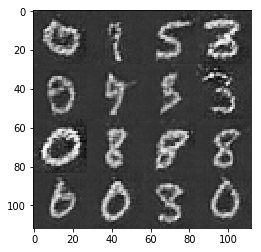

Epoch 1, batch 5510: discriminator loss 0.6554, generator loss 1.3091
Epoch 1, batch 5520: discriminator loss 0.6362, generator loss 2.2605
Epoch 1, batch 5530: discriminator loss 1.0191, generator loss 1.0065
Epoch 1, batch 5540: discriminator loss 0.6467, generator loss 1.6374
Epoch 1, batch 5550: discriminator loss 0.5123, generator loss 1.7916
Epoch 1, batch 5560: discriminator loss 0.4716, generator loss 1.6720
Epoch 1, batch 5570: discriminator loss 0.8521, generator loss 0.9047
Epoch 1, batch 5580: discriminator loss 0.3482, generator loss 2.2279
Epoch 1, batch 5590: discriminator loss 0.6474, generator loss 1.3195
Epoch 1, batch 5600: discriminator loss 0.6277, generator loss 2.1892


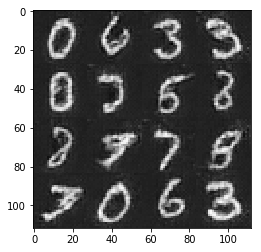

Epoch 1, batch 5610: discriminator loss 0.7252, generator loss 2.2087
Epoch 1, batch 5620: discriminator loss 0.8288, generator loss 1.1289
Epoch 1, batch 5630: discriminator loss 0.7175, generator loss 1.0407
Epoch 1, batch 5640: discriminator loss 0.8350, generator loss 0.8177
Epoch 1, batch 5650: discriminator loss 0.9305, generator loss 3.0719
Epoch 1, batch 5660: discriminator loss 0.3346, generator loss 2.0809
Epoch 1, batch 5670: discriminator loss 0.5648, generator loss 2.6714
Epoch 1, batch 5680: discriminator loss 0.7579, generator loss 1.4877
Epoch 1, batch 5690: discriminator loss 0.7384, generator loss 1.8956
Epoch 1, batch 5700: discriminator loss 0.4969, generator loss 1.7253


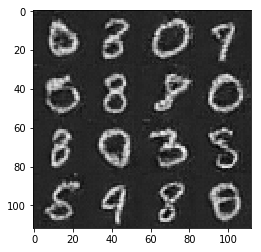

Epoch 1, batch 5710: discriminator loss 0.4919, generator loss 2.4502
Epoch 1, batch 5720: discriminator loss 0.7493, generator loss 1.1454
Epoch 1, batch 5730: discriminator loss 0.7792, generator loss 1.1914
Epoch 1, batch 5740: discriminator loss 0.6454, generator loss 1.4301
Epoch 1, batch 5750: discriminator loss 0.4800, generator loss 1.7324
Epoch 1, batch 5760: discriminator loss 0.5249, generator loss 1.9065
Epoch 1, batch 5770: discriminator loss 1.1898, generator loss 0.6509
Epoch 1, batch 5780: discriminator loss 0.5611, generator loss 1.7019
Epoch 1, batch 5790: discriminator loss 0.8028, generator loss 1.2736
Epoch 1, batch 5800: discriminator loss 0.5457, generator loss 1.4055


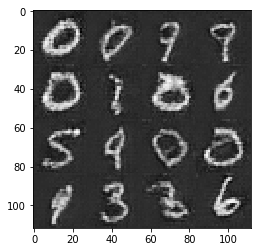

Epoch 1, batch 5810: discriminator loss 0.5385, generator loss 1.2246
Epoch 1, batch 5820: discriminator loss 1.5930, generator loss 0.5888
Epoch 1, batch 5830: discriminator loss 0.5900, generator loss 1.5747
Epoch 1, batch 5840: discriminator loss 0.6940, generator loss 1.1157
Epoch 1, batch 5850: discriminator loss 0.5053, generator loss 1.8278
Epoch 1, batch 5860: discriminator loss 0.5970, generator loss 3.2162
Epoch 1, batch 5870: discriminator loss 0.4989, generator loss 2.2667
Epoch 1, batch 5880: discriminator loss 1.0051, generator loss 0.8437
Epoch 1, batch 5890: discriminator loss 0.6266, generator loss 1.4102
Epoch 1, batch 5900: discriminator loss 0.2952, generator loss 1.9680


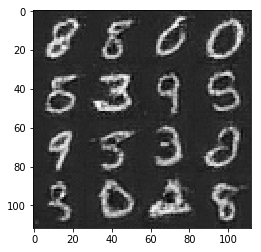

Epoch 1, batch 5910: discriminator loss 0.5119, generator loss 1.4522
Epoch 1, batch 5920: discriminator loss 0.4800, generator loss 2.1520
Epoch 1, batch 5930: discriminator loss 0.5172, generator loss 1.9808
Epoch 1, batch 5940: discriminator loss 0.3026, generator loss 2.0380
Epoch 1, batch 5950: discriminator loss 0.8545, generator loss 0.8824
Epoch 1, batch 5960: discriminator loss 0.9122, generator loss 1.2105
Epoch 1, batch 5970: discriminator loss 0.4583, generator loss 1.6661
Epoch 1, batch 5980: discriminator loss 0.5202, generator loss 1.6878
Epoch 1, batch 5990: discriminator loss 0.6277, generator loss 1.8500
Epoch 1, batch 6000: discriminator loss 0.5788, generator loss 1.5352


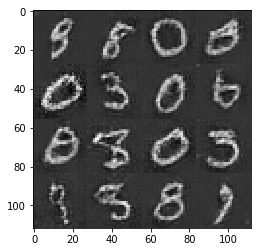

Epoch 1, batch 6010: discriminator loss 0.5813, generator loss 1.2543
Epoch 1, batch 6020: discriminator loss 0.5550, generator loss 1.3406
Epoch 1, batch 6030: discriminator loss 1.1193, generator loss 0.7383
Epoch 1, batch 6040: discriminator loss 0.7573, generator loss 1.5528
Epoch 1, batch 6050: discriminator loss 0.7410, generator loss 1.0401
Epoch 1, batch 6060: discriminator loss 0.6404, generator loss 1.6123
Epoch 1, batch 6070: discriminator loss 0.6277, generator loss 1.2201
Epoch 1, batch 6080: discriminator loss 1.0913, generator loss 0.6945
Epoch 1, batch 6090: discriminator loss 0.5075, generator loss 2.2708
Epoch 1, batch 6100: discriminator loss 0.6233, generator loss 2.1296


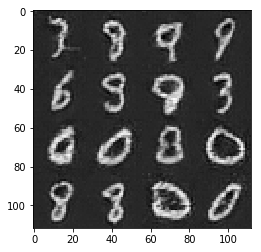

Epoch 1, batch 6110: discriminator loss 0.5298, generator loss 1.9209
Epoch 1, batch 6120: discriminator loss 0.4148, generator loss 1.4278
Epoch 1, batch 6130: discriminator loss 0.6278, generator loss 2.0123
Epoch 1, batch 6140: discriminator loss 0.6135, generator loss 1.3118
Epoch 1, batch 6150: discriminator loss 0.4638, generator loss 1.8749
Epoch 1, batch 6160: discriminator loss 0.6598, generator loss 1.3917
Epoch 1, batch 6170: discriminator loss 0.6489, generator loss 1.6561
Epoch 1, batch 6180: discriminator loss 0.8442, generator loss 1.2741
Epoch 1, batch 6190: discriminator loss 0.6614, generator loss 1.4305
Epoch 1, batch 6200: discriminator loss 0.5673, generator loss 1.6058


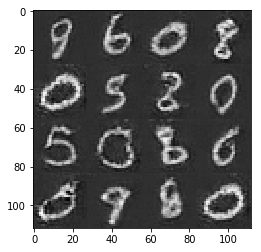

Epoch 1, batch 6210: discriminator loss 0.8844, generator loss 0.9133
Epoch 1, batch 6220: discriminator loss 0.6408, generator loss 1.0297
Epoch 1, batch 6230: discriminator loss 0.6708, generator loss 1.5097
Epoch 1, batch 6240: discriminator loss 0.7223, generator loss 0.9934
Epoch 1, batch 6250: discriminator loss 0.4802, generator loss 1.7235
Epoch 1, batch 6260: discriminator loss 0.5244, generator loss 1.3525
Epoch 1, batch 6270: discriminator loss 0.6451, generator loss 1.2226
Epoch 1, batch 6280: discriminator loss 0.6310, generator loss 2.9467
Epoch 1, batch 6290: discriminator loss 1.2776, generator loss 0.6540
Epoch 1, batch 6300: discriminator loss 0.4797, generator loss 1.8248


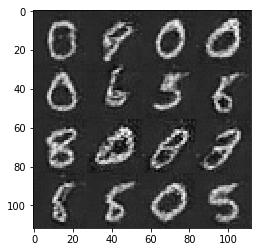

Epoch 1, batch 6310: discriminator loss 0.5747, generator loss 1.3058
Epoch 1, batch 6320: discriminator loss 0.6463, generator loss 2.4281
Epoch 1, batch 6330: discriminator loss 0.5425, generator loss 1.4055
Epoch 1, batch 6340: discriminator loss 0.8193, generator loss 0.9771
Epoch 1, batch 6350: discriminator loss 0.7804, generator loss 1.3545
Epoch 1, batch 6360: discriminator loss 0.3798, generator loss 1.9523
Epoch 1, batch 6370: discriminator loss 0.5256, generator loss 1.7044
Epoch 1, batch 6380: discriminator loss 0.7860, generator loss 1.0659
Epoch 1, batch 6390: discriminator loss 1.3825, generator loss 0.5019
Epoch 1, batch 6400: discriminator loss 1.1230, generator loss 0.6055


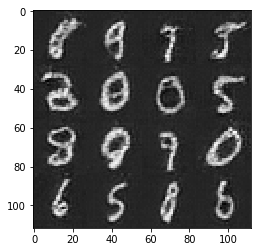

Epoch 1, batch 6410: discriminator loss 0.4983, generator loss 1.6195
Epoch 1, batch 6420: discriminator loss 0.5189, generator loss 1.5632
Epoch 1, batch 6430: discriminator loss 0.5023, generator loss 1.5970
Epoch 1, batch 6440: discriminator loss 0.8960, generator loss 2.4156
Epoch 1, batch 6450: discriminator loss 0.6266, generator loss 1.1192
Epoch 1, batch 6460: discriminator loss 0.7211, generator loss 1.8079
Epoch 1, batch 6470: discriminator loss 0.5606, generator loss 1.7641
Epoch 1, batch 6480: discriminator loss 0.8921, generator loss 1.0616
Epoch 1, batch 6490: discriminator loss 0.6717, generator loss 1.2211
Epoch 1, batch 6500: discriminator loss 0.5870, generator loss 1.4771


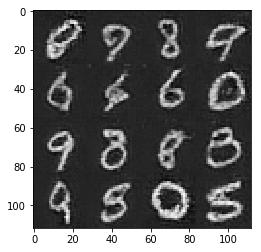

Epoch 1, batch 6510: discriminator loss 0.6947, generator loss 2.3428
Epoch 1, batch 6520: discriminator loss 0.4883, generator loss 1.3163
Epoch 1, batch 6530: discriminator loss 0.7610, generator loss 1.9854
Epoch 1, batch 6540: discriminator loss 0.6867, generator loss 1.1292
Epoch 1, batch 6550: discriminator loss 0.8024, generator loss 1.3001
Epoch 1, batch 6560: discriminator loss 0.4612, generator loss 1.4631
Epoch 1, batch 6570: discriminator loss 0.9499, generator loss 1.1325
Epoch 1, batch 6580: discriminator loss 1.1547, generator loss 0.5600
Epoch 1, batch 6590: discriminator loss 0.5114, generator loss 1.4386
Epoch 1, batch 6600: discriminator loss 0.6066, generator loss 1.5698


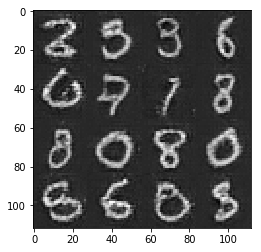

Epoch 1, batch 6610: discriminator loss 0.4233, generator loss 1.6946
Epoch 1, batch 6620: discriminator loss 0.6414, generator loss 1.0839
Epoch 1, batch 6630: discriminator loss 0.4253, generator loss 1.7638
Epoch 1, batch 6640: discriminator loss 0.4339, generator loss 2.3234
Epoch 1, batch 6650: discriminator loss 0.4900, generator loss 1.9293
Epoch 1, batch 6660: discriminator loss 0.6830, generator loss 1.2020
Epoch 1, batch 6670: discriminator loss 0.6525, generator loss 1.2166
Epoch 1, batch 6680: discriminator loss 0.6178, generator loss 1.4695
Epoch 1, batch 6690: discriminator loss 0.8857, generator loss 0.8457
Epoch 1, batch 6700: discriminator loss 1.2210, generator loss 0.5803


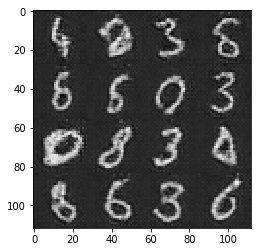

Epoch 1, batch 6710: discriminator loss 0.3493, generator loss 2.7148
Epoch 1, batch 6720: discriminator loss 0.2860, generator loss 2.1823
Epoch 1, batch 6730: discriminator loss 0.8376, generator loss 1.0727
Epoch 1, batch 6740: discriminator loss 0.6107, generator loss 1.8053
Epoch 1, batch 6750: discriminator loss 0.6205, generator loss 1.5726
Epoch 1, batch 6760: discriminator loss 0.5306, generator loss 1.7420
Epoch 1, batch 6770: discriminator loss 0.7145, generator loss 1.1273
Epoch 1, batch 6780: discriminator loss 0.7363, generator loss 1.2324
Epoch 1, batch 6790: discriminator loss 0.4022, generator loss 2.4510
Epoch 1, batch 6800: discriminator loss 0.5931, generator loss 1.6517


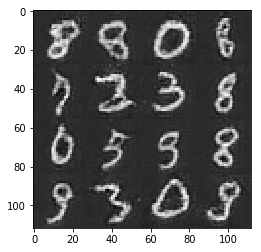

Epoch 1, batch 6810: discriminator loss 0.6841, generator loss 1.6755
Epoch 1, batch 6820: discriminator loss 0.8015, generator loss 1.0160
Epoch 1, batch 6830: discriminator loss 0.8339, generator loss 2.1450
Epoch 1, batch 6840: discriminator loss 0.5727, generator loss 1.9945
Epoch 1, batch 6850: discriminator loss 0.4899, generator loss 1.3898
Epoch 1, batch 6860: discriminator loss 0.5363, generator loss 1.1999
Epoch 1, batch 6870: discriminator loss 0.6168, generator loss 1.2316
Epoch 1, batch 6880: discriminator loss 0.8328, generator loss 1.0842
Epoch 1, batch 6890: discriminator loss 0.9972, generator loss 0.9129
Epoch 1, batch 6900: discriminator loss 0.8149, generator loss 1.3774


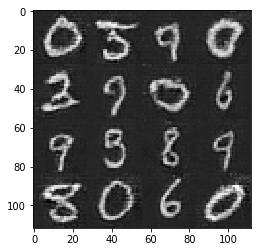

Epoch 1, batch 6910: discriminator loss 0.4694, generator loss 1.7924
Epoch 1, batch 6920: discriminator loss 0.5370, generator loss 1.4710
Epoch 1, batch 6930: discriminator loss 0.4990, generator loss 1.3761
Epoch 1, batch 6940: discriminator loss 0.5818, generator loss 1.9893
Epoch 1, batch 6950: discriminator loss 0.6185, generator loss 1.0403
Epoch 1, batch 6960: discriminator loss 0.6103, generator loss 1.7696
Epoch 1, batch 6970: discriminator loss 0.6904, generator loss 1.8082
Epoch 1, batch 6980: discriminator loss 0.3765, generator loss 1.7130
Epoch 1, batch 6990: discriminator loss 0.5020, generator loss 1.8287
Epoch 1, batch 7000: discriminator loss 0.4504, generator loss 1.5237


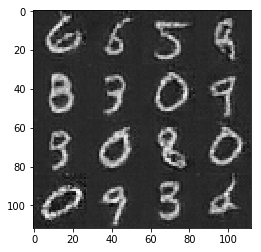

Epoch 1, batch 7010: discriminator loss 0.5601, generator loss 1.8330
Epoch 1, batch 7020: discriminator loss 0.5355, generator loss 1.4372
Epoch 1, batch 7030: discriminator loss 0.4515, generator loss 1.6997
Epoch 1, batch 7040: discriminator loss 0.8513, generator loss 2.8739
Epoch 1, batch 7050: discriminator loss 0.3392, generator loss 2.4320
Epoch 1, batch 7060: discriminator loss 0.5151, generator loss 1.6660
Epoch 1, batch 7070: discriminator loss 1.1003, generator loss 0.8275
Epoch 1, batch 7080: discriminator loss 0.4545, generator loss 3.0301
Epoch 1, batch 7090: discriminator loss 0.8636, generator loss 0.9552
Epoch 1, batch 7100: discriminator loss 0.3710, generator loss 1.7654


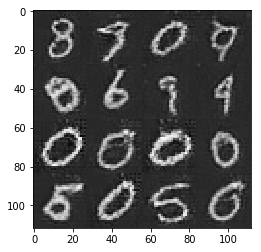

Epoch 1, batch 7110: discriminator loss 0.7664, generator loss 1.4979
Epoch 1, batch 7120: discriminator loss 0.4168, generator loss 1.8728
Epoch 1, batch 7130: discriminator loss 0.6293, generator loss 1.3895
Epoch 1, batch 7140: discriminator loss 0.7116, generator loss 2.2531
Epoch 1, batch 7150: discriminator loss 0.4700, generator loss 1.6858
Epoch 1, batch 7160: discriminator loss 0.5711, generator loss 1.6042
Epoch 1, batch 7170: discriminator loss 0.4572, generator loss 1.9880
Epoch 1, batch 7180: discriminator loss 0.5461, generator loss 2.2880
Epoch 1, batch 7190: discriminator loss 0.7094, generator loss 0.9990
Epoch 1, batch 7200: discriminator loss 0.5953, generator loss 1.1950


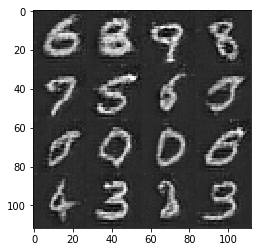

Epoch 1, batch 7210: discriminator loss 0.3369, generator loss 2.1575
Epoch 1, batch 7220: discriminator loss 0.2886, generator loss 2.7211
Epoch 1, batch 7230: discriminator loss 0.4858, generator loss 1.7051
Epoch 1, batch 7240: discriminator loss 1.0316, generator loss 0.8492
Epoch 1, batch 7250: discriminator loss 1.1240, generator loss 0.6034
Epoch 1, batch 7260: discriminator loss 0.7072, generator loss 1.3097
Epoch 1, batch 7270: discriminator loss 0.8676, generator loss 0.8936
Epoch 1, batch 7280: discriminator loss 0.8101, generator loss 1.1687
Epoch 1, batch 7290: discriminator loss 0.5974, generator loss 1.6405
Epoch 1, batch 7300: discriminator loss 0.3691, generator loss 1.8422


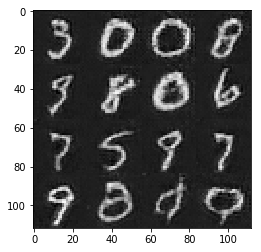

Epoch 1, batch 7310: discriminator loss 0.5263, generator loss 2.0594
Epoch 1, batch 7320: discriminator loss 0.5651, generator loss 2.2282
Epoch 1, batch 7330: discriminator loss 1.2398, generator loss 0.7590
Epoch 1, batch 7340: discriminator loss 0.3286, generator loss 2.1681
Epoch 1, batch 7350: discriminator loss 0.3518, generator loss 1.8227
Epoch 1, batch 7360: discriminator loss 0.5159, generator loss 2.0373
Epoch 1, batch 7370: discriminator loss 0.6544, generator loss 1.0927
Epoch 1, batch 7380: discriminator loss 0.6732, generator loss 1.2417
Epoch 1, batch 7390: discriminator loss 0.5276, generator loss 1.4835
Epoch 1, batch 7400: discriminator loss 0.5435, generator loss 1.4053


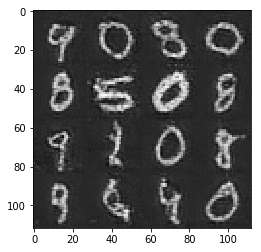

Epoch 1, batch 7410: discriminator loss 0.6466, generator loss 1.8536
Epoch 1, batch 7420: discriminator loss 0.5153, generator loss 1.3221
Epoch 1, batch 7430: discriminator loss 0.4563, generator loss 1.6199
Epoch 1, batch 7440: discriminator loss 0.6631, generator loss 2.5268
Epoch 1, batch 7450: discriminator loss 0.8787, generator loss 0.9588
Epoch 1, batch 7460: discriminator loss 0.5889, generator loss 1.4544
Epoch 1, batch 7470: discriminator loss 0.9647, generator loss 0.8029
Epoch 1, batch 7480: discriminator loss 0.3352, generator loss 2.3824
Epoch 1, batch 7490: discriminator loss 0.6099, generator loss 1.3677
Epoch 1, batch 7500: discriminator loss 0.5061, generator loss 2.0269


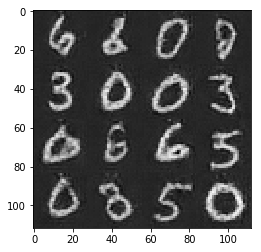

In [98]:
batch_size = 16
z_dim = 50
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0, batch 10: discriminator loss 2.6306, generator loss 0.0961
Epoch 0, batch 20: discriminator loss 0.2720, generator loss 2.2589
Epoch 0, batch 30: discriminator loss 0.5404, generator loss 0.9374
Epoch 0, batch 40: discriminator loss 0.2584, generator loss 7.9328
Epoch 0, batch 50: discriminator loss 0.4592, generator loss 1.8793
Epoch 0, batch 60: discriminator loss 0.4661, generator loss 2.7374
Epoch 0, batch 70: discriminator loss 0.3894, generator loss 2.7780
Epoch 0, batch 80: discriminator loss 0.3245, generator loss 2.6407
Epoch 0, batch 90: discriminator loss 0.5564, generator loss 3.7976
Epoch 0, batch 100: discriminator loss 0.5637, generator loss 1.7773


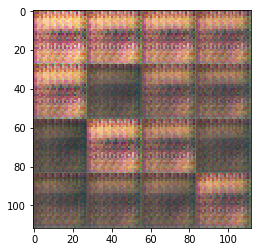

Epoch 0, batch 110: discriminator loss 0.8100, generator loss 0.8201
Epoch 0, batch 120: discriminator loss 0.5567, generator loss 1.9310
Epoch 0, batch 130: discriminator loss 0.5322, generator loss 2.6660
Epoch 0, batch 140: discriminator loss 0.6068, generator loss 1.0352
Epoch 0, batch 150: discriminator loss 0.8706, generator loss 1.6453
Epoch 0, batch 160: discriminator loss 0.7348, generator loss 2.1825
Epoch 0, batch 170: discriminator loss 0.7137, generator loss 1.1024
Epoch 0, batch 180: discriminator loss 0.5270, generator loss 1.6751
Epoch 0, batch 190: discriminator loss 0.7258, generator loss 1.3701
Epoch 0, batch 200: discriminator loss 0.9530, generator loss 1.7292


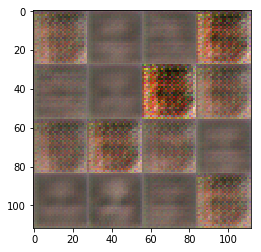

Epoch 0, batch 210: discriminator loss 0.6490, generator loss 1.2928
Epoch 0, batch 220: discriminator loss 0.4598, generator loss 1.9698
Epoch 0, batch 230: discriminator loss 0.7081, generator loss 1.3161
Epoch 0, batch 240: discriminator loss 0.7722, generator loss 1.1958
Epoch 0, batch 250: discriminator loss 0.9682, generator loss 1.1336
Epoch 0, batch 260: discriminator loss 1.2842, generator loss 0.8894
Epoch 0, batch 270: discriminator loss 2.0749, generator loss 0.3333
Epoch 0, batch 280: discriminator loss 0.9398, generator loss 1.1086
Epoch 0, batch 290: discriminator loss 1.3326, generator loss 0.4783
Epoch 0, batch 300: discriminator loss 1.2568, generator loss 1.3314


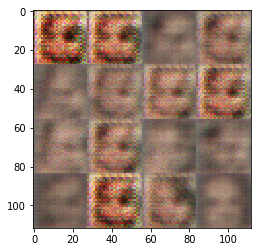

Epoch 0, batch 310: discriminator loss 1.1878, generator loss 0.9501
Epoch 0, batch 320: discriminator loss 1.0023, generator loss 0.8790
Epoch 0, batch 330: discriminator loss 0.8862, generator loss 0.9949
Epoch 0, batch 340: discriminator loss 0.7942, generator loss 1.2126
Epoch 0, batch 350: discriminator loss 0.9747, generator loss 0.9845
Epoch 0, batch 360: discriminator loss 0.6274, generator loss 1.3137
Epoch 0, batch 370: discriminator loss 1.0422, generator loss 0.6907
Epoch 0, batch 380: discriminator loss 0.6604, generator loss 1.0696
Epoch 0, batch 390: discriminator loss 0.7074, generator loss 1.2198
Epoch 0, batch 400: discriminator loss 0.6475, generator loss 1.4046


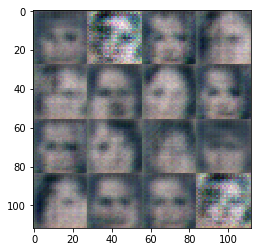

Epoch 0, batch 410: discriminator loss 1.0443, generator loss 0.7553
Epoch 0, batch 420: discriminator loss 0.8151, generator loss 1.1012
Epoch 0, batch 430: discriminator loss 0.8524, generator loss 1.4972
Epoch 0, batch 440: discriminator loss 0.7272, generator loss 1.1082
Epoch 0, batch 450: discriminator loss 0.9048, generator loss 1.1415
Epoch 0, batch 460: discriminator loss 1.0624, generator loss 1.4710
Epoch 0, batch 470: discriminator loss 1.0094, generator loss 1.1176
Epoch 0, batch 480: discriminator loss 1.1472, generator loss 1.1758
Epoch 0, batch 490: discriminator loss 1.1632, generator loss 0.8039
Epoch 0, batch 500: discriminator loss 1.1588, generator loss 1.2445


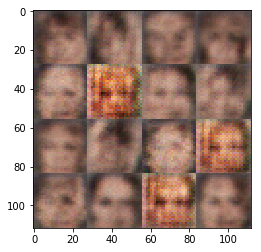

Epoch 0, batch 510: discriminator loss 1.2548, generator loss 0.6711
Epoch 0, batch 520: discriminator loss 1.0938, generator loss 1.2449
Epoch 0, batch 530: discriminator loss 0.9660, generator loss 0.9897
Epoch 0, batch 540: discriminator loss 1.1468, generator loss 1.3896
Epoch 0, batch 550: discriminator loss 0.6109, generator loss 1.2651
Epoch 0, batch 560: discriminator loss 0.9887, generator loss 0.8147
Epoch 0, batch 570: discriminator loss 0.8137, generator loss 0.9277
Epoch 0, batch 580: discriminator loss 0.9178, generator loss 1.1819
Epoch 0, batch 590: discriminator loss 1.0686, generator loss 0.8727
Epoch 0, batch 600: discriminator loss 0.9946, generator loss 0.7995


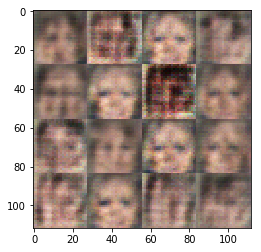

Epoch 0, batch 610: discriminator loss 0.9987, generator loss 0.7777
Epoch 0, batch 620: discriminator loss 0.9445, generator loss 1.0477
Epoch 0, batch 630: discriminator loss 0.8495, generator loss 1.0746
Epoch 0, batch 640: discriminator loss 0.9615, generator loss 0.9594
Epoch 0, batch 650: discriminator loss 0.6071, generator loss 1.3585
Epoch 0, batch 660: discriminator loss 1.0473, generator loss 0.9894
Epoch 0, batch 670: discriminator loss 0.6933, generator loss 1.0643
Epoch 0, batch 680: discriminator loss 0.9615, generator loss 1.0198
Epoch 0, batch 690: discriminator loss 0.7994, generator loss 1.1368
Epoch 0, batch 700: discriminator loss 1.1974, generator loss 0.6968


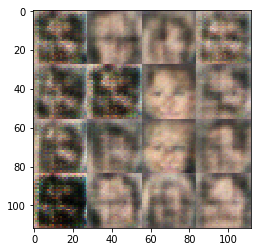

Epoch 0, batch 710: discriminator loss 1.1974, generator loss 1.2306
Epoch 0, batch 720: discriminator loss 1.1947, generator loss 0.6635
Epoch 0, batch 730: discriminator loss 1.0583, generator loss 1.1877
Epoch 0, batch 740: discriminator loss 0.8481, generator loss 1.3441
Epoch 0, batch 750: discriminator loss 1.0638, generator loss 0.9509
Epoch 0, batch 760: discriminator loss 1.1381, generator loss 1.6397
Epoch 0, batch 770: discriminator loss 0.9049, generator loss 0.7568
Epoch 0, batch 780: discriminator loss 0.8781, generator loss 2.3715
Epoch 0, batch 790: discriminator loss 0.7515, generator loss 1.1539
Epoch 0, batch 800: discriminator loss 0.9528, generator loss 1.2360


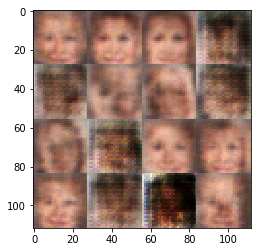

Epoch 0, batch 810: discriminator loss 0.7697, generator loss 1.1344
Epoch 0, batch 820: discriminator loss 1.5649, generator loss 0.7998
Epoch 0, batch 830: discriminator loss 1.5125, generator loss 0.6214
Epoch 0, batch 840: discriminator loss 1.3991, generator loss 0.9415
Epoch 0, batch 850: discriminator loss 1.3306, generator loss 0.7097
Epoch 0, batch 860: discriminator loss 1.1035, generator loss 1.1132
Epoch 0, batch 870: discriminator loss 0.9878, generator loss 0.8150
Epoch 0, batch 880: discriminator loss 0.7876, generator loss 1.2170
Epoch 0, batch 890: discriminator loss 1.2402, generator loss 0.7421
Epoch 0, batch 900: discriminator loss 0.8543, generator loss 1.3328


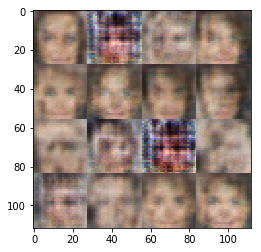

Epoch 0, batch 910: discriminator loss 0.9322, generator loss 1.3832
Epoch 0, batch 920: discriminator loss 1.1968, generator loss 0.8804
Epoch 0, batch 930: discriminator loss 0.9727, generator loss 1.0782
Epoch 0, batch 940: discriminator loss 0.9605, generator loss 1.0522
Epoch 0, batch 950: discriminator loss 0.8811, generator loss 1.3462
Epoch 0, batch 960: discriminator loss 0.8336, generator loss 1.0370
Epoch 0, batch 970: discriminator loss 1.0168, generator loss 0.9305
Epoch 0, batch 980: discriminator loss 0.7516, generator loss 1.2399
Epoch 0, batch 990: discriminator loss 0.9546, generator loss 1.1600
Epoch 0, batch 1000: discriminator loss 0.9289, generator loss 0.8389


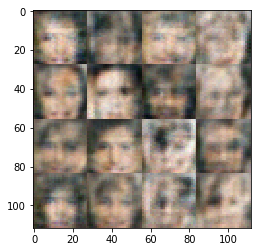

Epoch 0, batch 1010: discriminator loss 1.0728, generator loss 0.8965
Epoch 0, batch 1020: discriminator loss 1.1838, generator loss 0.7126
Epoch 0, batch 1030: discriminator loss 1.1197, generator loss 0.8354
Epoch 0, batch 1040: discriminator loss 1.4949, generator loss 1.0898
Epoch 0, batch 1050: discriminator loss 0.9092, generator loss 1.0703
Epoch 0, batch 1060: discriminator loss 1.1926, generator loss 1.0465
Epoch 0, batch 1070: discriminator loss 1.0112, generator loss 0.8526
Epoch 0, batch 1080: discriminator loss 1.1105, generator loss 1.0768
Epoch 0, batch 1090: discriminator loss 1.0047, generator loss 0.9381
Epoch 0, batch 1100: discriminator loss 0.9655, generator loss 1.3147


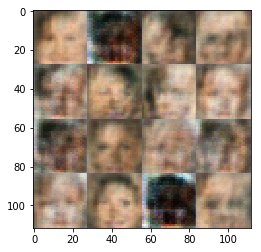

Epoch 0, batch 1110: discriminator loss 1.0531, generator loss 0.8632
Epoch 0, batch 1120: discriminator loss 1.3855, generator loss 1.4979
Epoch 0, batch 1130: discriminator loss 1.1761, generator loss 0.7544
Epoch 0, batch 1140: discriminator loss 1.5013, generator loss 0.5639
Epoch 0, batch 1150: discriminator loss 1.6431, generator loss 0.6605
Epoch 0, batch 1160: discriminator loss 0.8721, generator loss 1.2715
Epoch 0, batch 1170: discriminator loss 0.8974, generator loss 1.1282
Epoch 0, batch 1180: discriminator loss 1.2949, generator loss 0.9635
Epoch 0, batch 1190: discriminator loss 0.9293, generator loss 0.7303
Epoch 0, batch 1200: discriminator loss 1.2095, generator loss 0.8387


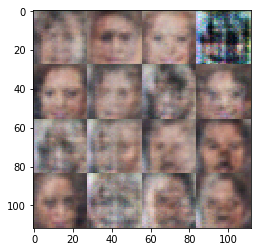

Epoch 0, batch 1210: discriminator loss 1.1282, generator loss 0.8502
Epoch 0, batch 1220: discriminator loss 1.0475, generator loss 1.0274
Epoch 0, batch 1230: discriminator loss 1.0955, generator loss 0.7532
Epoch 0, batch 1240: discriminator loss 1.2248, generator loss 1.1120
Epoch 0, batch 1250: discriminator loss 1.2359, generator loss 0.7633
Epoch 0, batch 1260: discriminator loss 1.3243, generator loss 0.7223
Epoch 0, batch 1270: discriminator loss 1.1849, generator loss 0.6981
Epoch 0, batch 1280: discriminator loss 1.2453, generator loss 0.6455
Epoch 0, batch 1290: discriminator loss 1.3343, generator loss 0.9162
Epoch 0, batch 1300: discriminator loss 1.0699, generator loss 0.9652


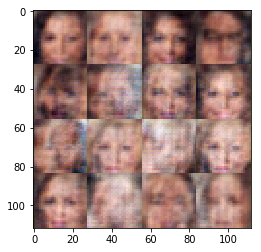

Epoch 0, batch 1310: discriminator loss 1.2673, generator loss 0.7833
Epoch 0, batch 1320: discriminator loss 1.1514, generator loss 0.8175
Epoch 0, batch 1330: discriminator loss 0.8296, generator loss 1.2598
Epoch 0, batch 1340: discriminator loss 1.3780, generator loss 0.7123
Epoch 0, batch 1350: discriminator loss 0.9921, generator loss 0.9873
Epoch 0, batch 1360: discriminator loss 1.2072, generator loss 0.8087
Epoch 0, batch 1370: discriminator loss 1.0616, generator loss 0.8853
Epoch 0, batch 1380: discriminator loss 1.0254, generator loss 1.3529
Epoch 0, batch 1390: discriminator loss 0.8406, generator loss 1.5725
Epoch 0, batch 1400: discriminator loss 1.3226, generator loss 0.7070


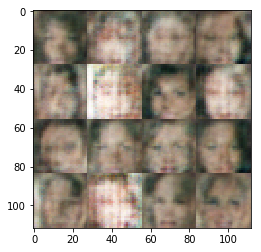

Epoch 0, batch 1410: discriminator loss 0.7782, generator loss 1.2976
Epoch 0, batch 1420: discriminator loss 1.4377, generator loss 1.1480
Epoch 0, batch 1430: discriminator loss 0.8207, generator loss 0.9879
Epoch 0, batch 1440: discriminator loss 1.4888, generator loss 0.7249
Epoch 0, batch 1450: discriminator loss 1.3999, generator loss 0.5853
Epoch 0, batch 1460: discriminator loss 1.2595, generator loss 0.6530
Epoch 0, batch 1470: discriminator loss 1.1209, generator loss 0.8625
Epoch 0, batch 1480: discriminator loss 0.9655, generator loss 0.9224
Epoch 0, batch 1490: discriminator loss 1.1494, generator loss 0.7975
Epoch 0, batch 1500: discriminator loss 1.6465, generator loss 1.5466


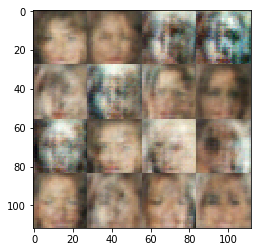

Epoch 0, batch 1510: discriminator loss 0.9815, generator loss 0.8732
Epoch 0, batch 1520: discriminator loss 1.1932, generator loss 0.7317
Epoch 0, batch 1530: discriminator loss 1.1662, generator loss 0.7741
Epoch 0, batch 1540: discriminator loss 0.7033, generator loss 1.0230
Epoch 0, batch 1550: discriminator loss 0.8896, generator loss 1.1776
Epoch 0, batch 1560: discriminator loss 1.3941, generator loss 1.0346
Epoch 0, batch 1570: discriminator loss 1.2187, generator loss 0.7527
Epoch 0, batch 1580: discriminator loss 0.8120, generator loss 1.1808
Epoch 0, batch 1590: discriminator loss 1.2281, generator loss 0.8355
Epoch 0, batch 1600: discriminator loss 1.4825, generator loss 0.9542


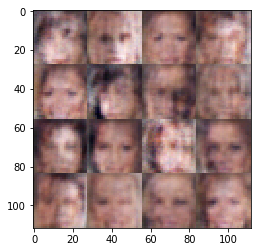

Epoch 0, batch 1610: discriminator loss 1.1320, generator loss 1.0450
Epoch 0, batch 1620: discriminator loss 1.2505, generator loss 0.8028
Epoch 0, batch 1630: discriminator loss 1.1671, generator loss 0.8371
Epoch 0, batch 1640: discriminator loss 1.0252, generator loss 1.1195
Epoch 0, batch 1650: discriminator loss 1.1326, generator loss 0.8310
Epoch 0, batch 1660: discriminator loss 1.1393, generator loss 0.7506
Epoch 0, batch 1670: discriminator loss 1.0027, generator loss 0.9649
Epoch 0, batch 1680: discriminator loss 0.9283, generator loss 0.9574
Epoch 0, batch 1690: discriminator loss 1.0248, generator loss 1.3255
Epoch 0, batch 1700: discriminator loss 1.1746, generator loss 0.8716


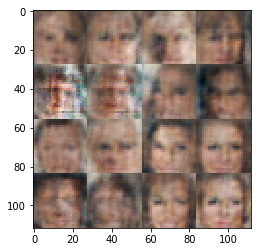

Epoch 0, batch 1710: discriminator loss 1.1071, generator loss 1.0384
Epoch 0, batch 1720: discriminator loss 1.1227, generator loss 0.7713
Epoch 0, batch 1730: discriminator loss 0.9544, generator loss 1.2169
Epoch 0, batch 1740: discriminator loss 1.2670, generator loss 0.9388
Epoch 0, batch 1750: discriminator loss 1.2294, generator loss 0.7236
Epoch 0, batch 1760: discriminator loss 1.0654, generator loss 0.8035
Epoch 0, batch 1770: discriminator loss 1.1586, generator loss 0.8782
Epoch 0, batch 1780: discriminator loss 1.0755, generator loss 1.1096
Epoch 0, batch 1790: discriminator loss 1.7756, generator loss 0.4091
Epoch 0, batch 1800: discriminator loss 1.2977, generator loss 1.2228


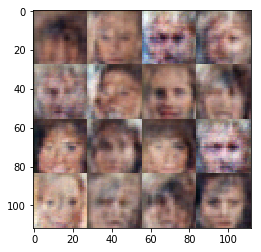

Epoch 0, batch 1810: discriminator loss 0.6084, generator loss 1.4491
Epoch 0, batch 1820: discriminator loss 1.1049, generator loss 1.2312
Epoch 0, batch 1830: discriminator loss 0.7838, generator loss 1.1667
Epoch 0, batch 1840: discriminator loss 1.3291, generator loss 0.5743
Epoch 0, batch 1850: discriminator loss 1.2418, generator loss 0.8971
Epoch 0, batch 1860: discriminator loss 1.1122, generator loss 0.9428
Epoch 0, batch 1870: discriminator loss 1.0224, generator loss 1.1769
Epoch 0, batch 1880: discriminator loss 1.0452, generator loss 0.9699
Epoch 0, batch 1890: discriminator loss 0.8484, generator loss 1.1517
Epoch 0, batch 1900: discriminator loss 1.0600, generator loss 0.9697


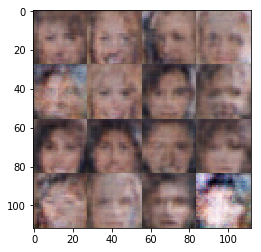

Epoch 0, batch 1910: discriminator loss 1.2233, generator loss 0.8200
Epoch 0, batch 1920: discriminator loss 1.1898, generator loss 0.8553
Epoch 0, batch 1930: discriminator loss 0.7657, generator loss 1.3150
Epoch 0, batch 1940: discriminator loss 0.9835, generator loss 1.0233
Epoch 0, batch 1950: discriminator loss 1.3593, generator loss 0.5939
Epoch 0, batch 1960: discriminator loss 1.0328, generator loss 1.0190
Epoch 0, batch 1970: discriminator loss 1.1266, generator loss 0.8400
Epoch 0, batch 1980: discriminator loss 1.0515, generator loss 0.8094
Epoch 0, batch 1990: discriminator loss 1.2059, generator loss 0.7720
Epoch 0, batch 2000: discriminator loss 1.3366, generator loss 1.5882


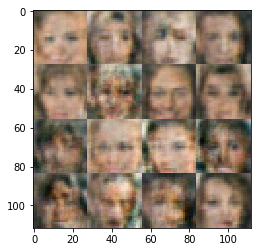

Epoch 0, batch 2010: discriminator loss 1.1197, generator loss 0.7757
Epoch 0, batch 2020: discriminator loss 1.0509, generator loss 0.7839
Epoch 0, batch 2030: discriminator loss 0.9740, generator loss 1.0152
Epoch 0, batch 2040: discriminator loss 1.1264, generator loss 0.7193
Epoch 0, batch 2050: discriminator loss 1.2075, generator loss 0.8422
Epoch 0, batch 2060: discriminator loss 0.8909, generator loss 1.4354
Epoch 0, batch 2070: discriminator loss 0.9816, generator loss 0.9828
Epoch 0, batch 2080: discriminator loss 1.0655, generator loss 1.0723
Epoch 0, batch 2090: discriminator loss 1.0509, generator loss 0.8662
Epoch 0, batch 2100: discriminator loss 1.3208, generator loss 0.6122


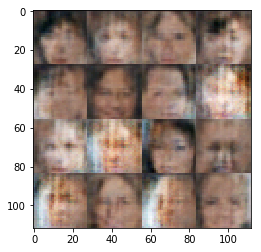

Epoch 0, batch 2110: discriminator loss 1.0135, generator loss 0.7886
Epoch 0, batch 2120: discriminator loss 1.3775, generator loss 0.5548
Epoch 0, batch 2130: discriminator loss 0.9392, generator loss 0.9025
Epoch 0, batch 2140: discriminator loss 1.1739, generator loss 0.7362
Epoch 0, batch 2150: discriminator loss 1.0696, generator loss 0.7929
Epoch 0, batch 2160: discriminator loss 1.1878, generator loss 0.9223
Epoch 0, batch 2170: discriminator loss 0.8716, generator loss 1.4508
Epoch 0, batch 2180: discriminator loss 1.2241, generator loss 0.9325
Epoch 0, batch 2190: discriminator loss 0.8812, generator loss 1.0388
Epoch 0, batch 2200: discriminator loss 1.1888, generator loss 0.7164


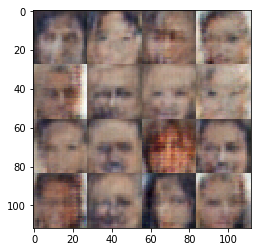

Epoch 0, batch 2210: discriminator loss 1.0773, generator loss 1.0294
Epoch 0, batch 2220: discriminator loss 1.2085, generator loss 0.7684
Epoch 0, batch 2230: discriminator loss 0.9040, generator loss 0.8735
Epoch 0, batch 2240: discriminator loss 0.8919, generator loss 0.8741
Epoch 0, batch 2250: discriminator loss 1.3522, generator loss 0.6650
Epoch 0, batch 2260: discriminator loss 1.0394, generator loss 0.8584
Epoch 0, batch 2270: discriminator loss 1.0660, generator loss 0.8661
Epoch 0, batch 2280: discriminator loss 0.9988, generator loss 1.0137
Epoch 0, batch 2290: discriminator loss 1.2010, generator loss 0.7244
Epoch 0, batch 2300: discriminator loss 1.0290, generator loss 1.0581


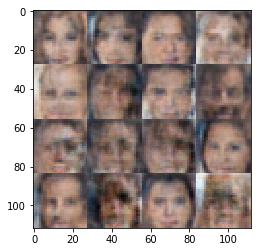

Epoch 0, batch 2310: discriminator loss 0.9055, generator loss 1.0295
Epoch 0, batch 2320: discriminator loss 1.0414, generator loss 1.1309
Epoch 0, batch 2330: discriminator loss 1.0928, generator loss 0.9462
Epoch 0, batch 2340: discriminator loss 1.1130, generator loss 0.7622
Epoch 0, batch 2350: discriminator loss 1.0168, generator loss 0.9053
Epoch 0, batch 2360: discriminator loss 1.0495, generator loss 0.7295
Epoch 0, batch 2370: discriminator loss 0.9993, generator loss 0.9061
Epoch 0, batch 2380: discriminator loss 1.2258, generator loss 0.8137
Epoch 0, batch 2390: discriminator loss 1.2941, generator loss 0.7672
Epoch 0, batch 2400: discriminator loss 1.0382, generator loss 0.8145


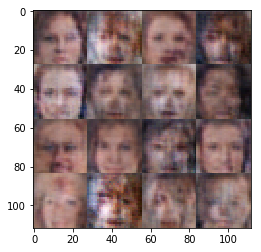

Epoch 0, batch 2410: discriminator loss 0.9404, generator loss 1.0594
Epoch 0, batch 2420: discriminator loss 0.9695, generator loss 0.9322
Epoch 0, batch 2430: discriminator loss 1.2114, generator loss 0.7151
Epoch 0, batch 2440: discriminator loss 1.2767, generator loss 0.6445
Epoch 0, batch 2450: discriminator loss 1.0425, generator loss 0.8729
Epoch 0, batch 2460: discriminator loss 1.1401, generator loss 0.7186
Epoch 0, batch 2470: discriminator loss 0.9350, generator loss 1.0612
Epoch 0, batch 2480: discriminator loss 1.2269, generator loss 0.7416
Epoch 0, batch 2490: discriminator loss 1.1055, generator loss 1.3241
Epoch 0, batch 2500: discriminator loss 1.3000, generator loss 0.7076


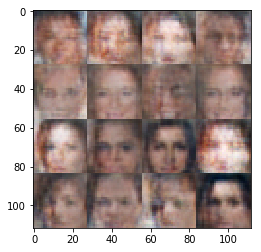

Epoch 0, batch 2510: discriminator loss 1.0638, generator loss 0.9688
Epoch 0, batch 2520: discriminator loss 1.1522, generator loss 1.0627
Epoch 0, batch 2530: discriminator loss 1.1227, generator loss 1.0296
Epoch 0, batch 2540: discriminator loss 1.1347, generator loss 1.2188
Epoch 0, batch 2550: discriminator loss 1.3037, generator loss 0.7652
Epoch 0, batch 2560: discriminator loss 1.1567, generator loss 0.7107
Epoch 0, batch 2570: discriminator loss 0.9480, generator loss 0.8759
Epoch 0, batch 2580: discriminator loss 1.1069, generator loss 0.8857
Epoch 0, batch 2590: discriminator loss 0.9833, generator loss 1.0090
Epoch 0, batch 2600: discriminator loss 1.0776, generator loss 0.8435


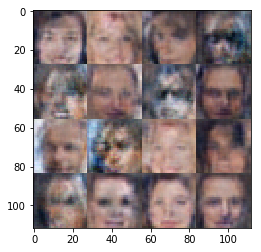

Epoch 0, batch 2610: discriminator loss 1.1418, generator loss 0.8742
Epoch 0, batch 2620: discriminator loss 0.8460, generator loss 1.0635
Epoch 0, batch 2630: discriminator loss 0.8461, generator loss 1.0795
Epoch 0, batch 2640: discriminator loss 0.8851, generator loss 1.1553
Epoch 0, batch 2650: discriminator loss 1.0376, generator loss 1.0109
Epoch 0, batch 2660: discriminator loss 0.9731, generator loss 0.8364
Epoch 0, batch 2670: discriminator loss 1.0302, generator loss 0.8605
Epoch 0, batch 2680: discriminator loss 1.1075, generator loss 0.6515
Epoch 0, batch 2690: discriminator loss 1.0392, generator loss 1.1779
Epoch 0, batch 2700: discriminator loss 1.0722, generator loss 0.7710


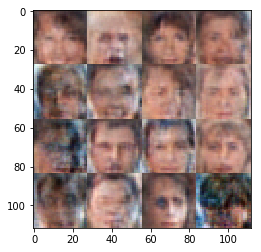

Epoch 0, batch 2710: discriminator loss 1.0893, generator loss 1.2249
Epoch 0, batch 2720: discriminator loss 1.1500, generator loss 0.7706
Epoch 0, batch 2730: discriminator loss 0.6578, generator loss 1.1461
Epoch 0, batch 2740: discriminator loss 0.9608, generator loss 0.9420
Epoch 0, batch 2750: discriminator loss 1.3145, generator loss 0.9168
Epoch 0, batch 2760: discriminator loss 1.0580, generator loss 0.8023
Epoch 0, batch 2770: discriminator loss 1.1326, generator loss 0.9992
Epoch 0, batch 2780: discriminator loss 0.9968, generator loss 1.0141
Epoch 0, batch 2790: discriminator loss 1.0140, generator loss 1.0062
Epoch 0, batch 2800: discriminator loss 0.9658, generator loss 0.8690


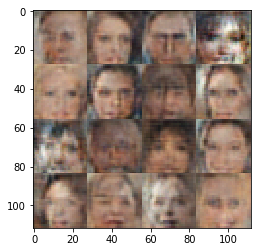

Epoch 0, batch 2810: discriminator loss 1.1960, generator loss 0.9636
Epoch 0, batch 2820: discriminator loss 1.1979, generator loss 0.7795
Epoch 0, batch 2830: discriminator loss 1.2042, generator loss 0.6873
Epoch 0, batch 2840: discriminator loss 1.0123, generator loss 0.6696
Epoch 0, batch 2850: discriminator loss 1.1010, generator loss 0.8271
Epoch 0, batch 2860: discriminator loss 1.2980, generator loss 0.6034
Epoch 0, batch 2870: discriminator loss 1.0508, generator loss 0.8081
Epoch 0, batch 2880: discriminator loss 0.8899, generator loss 1.0641
Epoch 0, batch 2890: discriminator loss 1.0714, generator loss 0.9348
Epoch 0, batch 2900: discriminator loss 1.1410, generator loss 0.7812


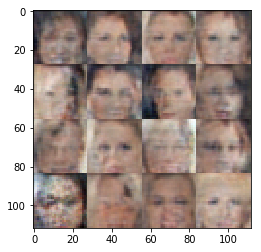

Epoch 0, batch 2910: discriminator loss 1.0160, generator loss 1.1125
Epoch 0, batch 2920: discriminator loss 1.0813, generator loss 0.7590
Epoch 0, batch 2930: discriminator loss 0.9952, generator loss 1.0489
Epoch 0, batch 2940: discriminator loss 1.4551, generator loss 0.7442
Epoch 0, batch 2950: discriminator loss 0.9682, generator loss 1.0617
Epoch 0, batch 2960: discriminator loss 0.9631, generator loss 1.1307
Epoch 0, batch 2970: discriminator loss 0.9780, generator loss 1.2366
Epoch 0, batch 2980: discriminator loss 0.8642, generator loss 0.9876
Epoch 0, batch 2990: discriminator loss 1.1453, generator loss 0.7735
Epoch 0, batch 3000: discriminator loss 1.1811, generator loss 0.7252


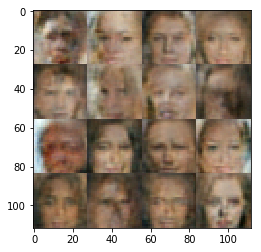

Epoch 0, batch 3010: discriminator loss 1.0186, generator loss 0.8072
Epoch 0, batch 3020: discriminator loss 1.0942, generator loss 0.8653
Epoch 0, batch 3030: discriminator loss 0.9723, generator loss 1.3005
Epoch 0, batch 3040: discriminator loss 0.8511, generator loss 1.0382
Epoch 0, batch 3050: discriminator loss 1.0051, generator loss 1.0826
Epoch 0, batch 3060: discriminator loss 0.9297, generator loss 1.0082
Epoch 0, batch 3070: discriminator loss 1.2357, generator loss 0.5975
Epoch 0, batch 3080: discriminator loss 1.0003, generator loss 1.0041
Epoch 0, batch 3090: discriminator loss 0.9723, generator loss 0.8696
Epoch 0, batch 3100: discriminator loss 1.0037, generator loss 0.9509


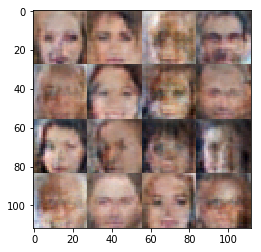

Epoch 0, batch 3110: discriminator loss 0.9765, generator loss 0.9954
Epoch 0, batch 3120: discriminator loss 0.9607, generator loss 0.8996
Epoch 0, batch 3130: discriminator loss 1.2140, generator loss 0.6669
Epoch 0, batch 3140: discriminator loss 1.2822, generator loss 0.6333
Epoch 0, batch 3150: discriminator loss 0.8584, generator loss 0.9538
Epoch 0, batch 3160: discriminator loss 0.9223, generator loss 0.9301
Epoch 0, batch 3170: discriminator loss 0.8724, generator loss 0.8219
Epoch 0, batch 3180: discriminator loss 1.0781, generator loss 0.8518
Epoch 0, batch 3190: discriminator loss 1.1973, generator loss 0.6376
Epoch 0, batch 3200: discriminator loss 1.2073, generator loss 0.7777


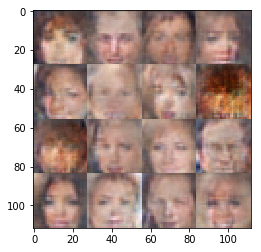

Epoch 0, batch 3210: discriminator loss 0.9699, generator loss 0.8593
Epoch 0, batch 3220: discriminator loss 0.9855, generator loss 0.9254
Epoch 0, batch 3230: discriminator loss 1.0999, generator loss 0.9269
Epoch 0, batch 3240: discriminator loss 0.8938, generator loss 1.0349
Epoch 0, batch 3250: discriminator loss 0.9061, generator loss 1.0171
Epoch 0, batch 3260: discriminator loss 1.1659, generator loss 0.9451
Epoch 0, batch 3270: discriminator loss 1.3644, generator loss 0.6306
Epoch 0, batch 3280: discriminator loss 1.1738, generator loss 0.8293
Epoch 0, batch 3290: discriminator loss 1.0212, generator loss 0.9176
Epoch 0, batch 3300: discriminator loss 0.9541, generator loss 1.1492


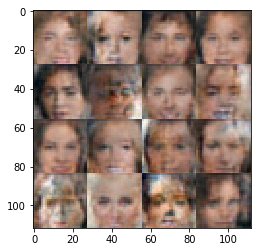

Epoch 0, batch 3310: discriminator loss 0.9831, generator loss 0.9806
Epoch 0, batch 3320: discriminator loss 1.0968, generator loss 0.8097
Epoch 0, batch 3330: discriminator loss 1.1844, generator loss 0.7599
Epoch 0, batch 3340: discriminator loss 0.9310, generator loss 1.0615
Epoch 0, batch 3350: discriminator loss 0.9911, generator loss 1.0038
Epoch 0, batch 3360: discriminator loss 1.0570, generator loss 0.8688
Epoch 0, batch 3370: discriminator loss 1.0292, generator loss 1.0584
Epoch 0, batch 3380: discriminator loss 1.0412, generator loss 1.4106
Epoch 0, batch 3390: discriminator loss 1.1457, generator loss 0.8418
Epoch 0, batch 3400: discriminator loss 0.9475, generator loss 1.5893


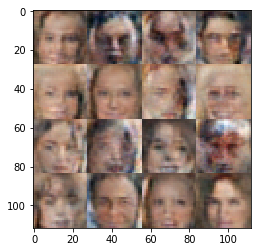

Epoch 0, batch 3410: discriminator loss 1.2118, generator loss 0.6695
Epoch 0, batch 3420: discriminator loss 0.9428, generator loss 0.9854
Epoch 0, batch 3430: discriminator loss 1.0714, generator loss 0.9687
Epoch 0, batch 3440: discriminator loss 0.9000, generator loss 0.9739
Epoch 0, batch 3450: discriminator loss 1.0631, generator loss 1.1705
Epoch 0, batch 3460: discriminator loss 1.0800, generator loss 0.8498
Epoch 0, batch 3470: discriminator loss 1.1384, generator loss 0.9304
Epoch 0, batch 3480: discriminator loss 0.9676, generator loss 1.0439
Epoch 0, batch 3490: discriminator loss 1.2486, generator loss 1.0339
Epoch 0, batch 3500: discriminator loss 0.9112, generator loss 0.9938


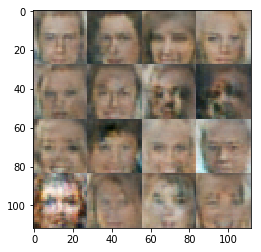

Epoch 0, batch 3510: discriminator loss 0.9497, generator loss 1.1250
Epoch 0, batch 3520: discriminator loss 1.0097, generator loss 0.8748
Epoch 0, batch 3530: discriminator loss 1.2672, generator loss 0.6484
Epoch 0, batch 3540: discriminator loss 0.8640, generator loss 1.3507
Epoch 0, batch 3550: discriminator loss 0.9447, generator loss 1.0456
Epoch 0, batch 3560: discriminator loss 0.9596, generator loss 1.0318
Epoch 0, batch 3570: discriminator loss 0.9816, generator loss 0.9351
Epoch 0, batch 3580: discriminator loss 0.9079, generator loss 1.1408
Epoch 0, batch 3590: discriminator loss 0.9607, generator loss 1.0040
Epoch 0, batch 3600: discriminator loss 0.9004, generator loss 1.2047


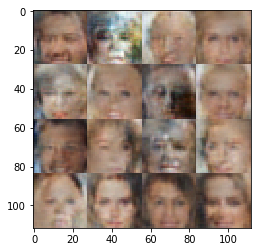

Epoch 0, batch 3610: discriminator loss 1.0337, generator loss 0.9167
Epoch 0, batch 3620: discriminator loss 1.0908, generator loss 0.9522
Epoch 0, batch 3630: discriminator loss 0.9136, generator loss 1.1187
Epoch 0, batch 3640: discriminator loss 0.9005, generator loss 1.1656
Epoch 0, batch 3650: discriminator loss 0.9288, generator loss 0.8998
Epoch 0, batch 3660: discriminator loss 0.7895, generator loss 1.1770
Epoch 0, batch 3670: discriminator loss 1.2768, generator loss 0.5871
Epoch 0, batch 3680: discriminator loss 0.7834, generator loss 1.2608
Epoch 0, batch 3690: discriminator loss 0.8588, generator loss 1.0953
Epoch 0, batch 3700: discriminator loss 1.2178, generator loss 0.8852


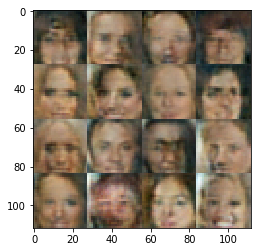

Epoch 0, batch 3710: discriminator loss 0.9679, generator loss 1.3267
Epoch 0, batch 3720: discriminator loss 1.0408, generator loss 0.8197
Epoch 0, batch 3730: discriminator loss 0.9971, generator loss 0.7740
Epoch 0, batch 3740: discriminator loss 0.8427, generator loss 1.0551
Epoch 0, batch 3750: discriminator loss 0.9348, generator loss 1.0220
Epoch 0, batch 3760: discriminator loss 0.9325, generator loss 0.9352
Epoch 0, batch 3770: discriminator loss 1.1976, generator loss 1.5776
Epoch 0, batch 3780: discriminator loss 1.0178, generator loss 0.7878
Epoch 0, batch 3790: discriminator loss 1.2956, generator loss 0.7720
Epoch 0, batch 3800: discriminator loss 0.9801, generator loss 0.9541


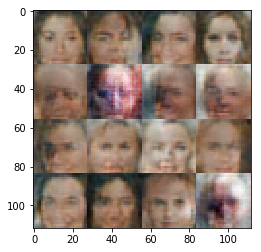

Epoch 0, batch 3810: discriminator loss 0.9443, generator loss 0.8668
Epoch 0, batch 3820: discriminator loss 1.1852, generator loss 0.9495
Epoch 0, batch 3830: discriminator loss 1.1244, generator loss 0.8147
Epoch 0, batch 3840: discriminator loss 0.9345, generator loss 0.9507
Epoch 0, batch 3850: discriminator loss 0.9234, generator loss 0.9980
Epoch 0, batch 3860: discriminator loss 0.9317, generator loss 0.8472
Epoch 0, batch 3870: discriminator loss 1.2284, generator loss 0.6428
Epoch 0, batch 3880: discriminator loss 1.1022, generator loss 0.7789
Epoch 0, batch 3890: discriminator loss 0.8941, generator loss 0.9822
Epoch 0, batch 3900: discriminator loss 0.9303, generator loss 0.9694


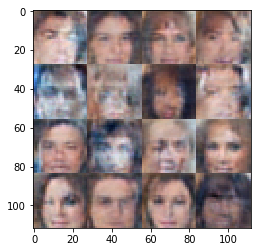

Epoch 0, batch 3910: discriminator loss 1.0888, generator loss 0.8540
Epoch 0, batch 3920: discriminator loss 0.9891, generator loss 0.9585
Epoch 0, batch 3930: discriminator loss 0.8711, generator loss 0.9723
Epoch 0, batch 3940: discriminator loss 1.1881, generator loss 0.7104
Epoch 0, batch 3950: discriminator loss 1.1231, generator loss 1.0781
Epoch 0, batch 3960: discriminator loss 0.8627, generator loss 0.9976
Epoch 0, batch 3970: discriminator loss 1.0301, generator loss 0.8690
Epoch 0, batch 3980: discriminator loss 0.9975, generator loss 0.9734
Epoch 0, batch 3990: discriminator loss 0.9497, generator loss 0.9386
Epoch 0, batch 4000: discriminator loss 0.9252, generator loss 0.9207


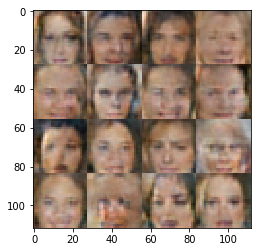

Epoch 0, batch 4010: discriminator loss 0.8878, generator loss 1.0450
Epoch 0, batch 4020: discriminator loss 1.0457, generator loss 0.8638
Epoch 0, batch 4030: discriminator loss 0.9470, generator loss 0.8410
Epoch 0, batch 4040: discriminator loss 1.0304, generator loss 0.9188
Epoch 0, batch 4050: discriminator loss 1.0180, generator loss 0.7715
Epoch 0, batch 4060: discriminator loss 1.0761, generator loss 0.8538
Epoch 0, batch 4070: discriminator loss 0.9121, generator loss 1.1322
Epoch 0, batch 4080: discriminator loss 1.0457, generator loss 1.0102
Epoch 0, batch 4090: discriminator loss 0.7859, generator loss 1.0686
Epoch 0, batch 4100: discriminator loss 1.0608, generator loss 0.9054


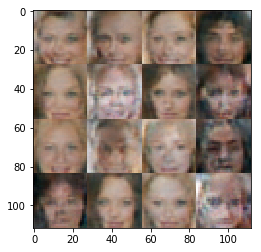

Epoch 0, batch 4110: discriminator loss 1.0296, generator loss 0.7603
Epoch 0, batch 4120: discriminator loss 0.8997, generator loss 0.9382
Epoch 0, batch 4130: discriminator loss 0.9858, generator loss 0.7563
Epoch 0, batch 4140: discriminator loss 0.8855, generator loss 0.9977
Epoch 0, batch 4150: discriminator loss 0.7763, generator loss 1.6822
Epoch 0, batch 4160: discriminator loss 0.8736, generator loss 0.9121
Epoch 0, batch 4170: discriminator loss 0.9732, generator loss 0.9493
Epoch 0, batch 4180: discriminator loss 1.0616, generator loss 0.9081
Epoch 0, batch 4190: discriminator loss 1.0191, generator loss 0.8178
Epoch 0, batch 4200: discriminator loss 0.9357, generator loss 1.0450


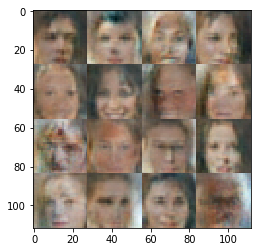

Epoch 0, batch 4210: discriminator loss 0.9234, generator loss 1.1690
Epoch 0, batch 4220: discriminator loss 0.9956, generator loss 1.0226
Epoch 0, batch 4230: discriminator loss 0.9448, generator loss 1.1082
Epoch 0, batch 4240: discriminator loss 1.0650, generator loss 0.8957
Epoch 0, batch 4250: discriminator loss 0.9518, generator loss 0.9599
Epoch 0, batch 4260: discriminator loss 1.1869, generator loss 1.1108
Epoch 0, batch 4270: discriminator loss 0.8767, generator loss 1.1287
Epoch 0, batch 4280: discriminator loss 0.9415, generator loss 0.9678
Epoch 0, batch 4290: discriminator loss 1.2321, generator loss 0.7879
Epoch 0, batch 4300: discriminator loss 1.2441, generator loss 0.6739


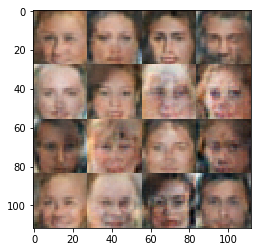

Epoch 0, batch 4310: discriminator loss 0.7762, generator loss 1.1955
Epoch 0, batch 4320: discriminator loss 1.0749, generator loss 0.8289
Epoch 0, batch 4330: discriminator loss 0.9206, generator loss 1.0664
Epoch 0, batch 4340: discriminator loss 0.9281, generator loss 1.1721
Epoch 0, batch 4350: discriminator loss 0.9024, generator loss 1.0399
Epoch 0, batch 4360: discriminator loss 0.9788, generator loss 1.0286
Epoch 0, batch 4370: discriminator loss 1.1813, generator loss 0.7421
Epoch 0, batch 4380: discriminator loss 1.0181, generator loss 0.7067
Epoch 0, batch 4390: discriminator loss 1.0055, generator loss 0.9683
Epoch 0, batch 4400: discriminator loss 1.0320, generator loss 0.9713


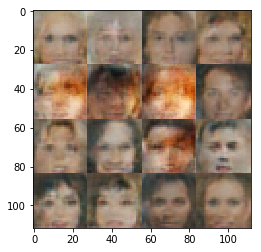

Epoch 0, batch 4410: discriminator loss 0.9597, generator loss 0.8936
Epoch 0, batch 4420: discriminator loss 0.9380, generator loss 0.9608
Epoch 0, batch 4430: discriminator loss 0.8685, generator loss 1.0610
Epoch 0, batch 4440: discriminator loss 1.0348, generator loss 1.0405
Epoch 0, batch 4450: discriminator loss 0.8501, generator loss 1.1853
Epoch 0, batch 4460: discriminator loss 1.2391, generator loss 0.6930
Epoch 0, batch 4470: discriminator loss 0.9271, generator loss 0.9762
Epoch 0, batch 4480: discriminator loss 1.1834, generator loss 0.7647
Epoch 0, batch 4490: discriminator loss 1.1099, generator loss 0.8259
Epoch 0, batch 4500: discriminator loss 0.9660, generator loss 0.8862


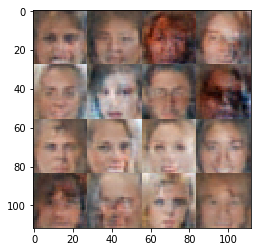

Epoch 0, batch 4510: discriminator loss 1.0050, generator loss 0.9224
Epoch 0, batch 4520: discriminator loss 0.9743, generator loss 1.0528
Epoch 0, batch 4530: discriminator loss 0.7989, generator loss 1.1022
Epoch 0, batch 4540: discriminator loss 0.9770, generator loss 0.9354
Epoch 0, batch 4550: discriminator loss 0.9770, generator loss 0.9242
Epoch 0, batch 4560: discriminator loss 1.0480, generator loss 1.3106
Epoch 0, batch 4570: discriminator loss 0.7420, generator loss 1.2719
Epoch 0, batch 4580: discriminator loss 1.1420, generator loss 0.8102
Epoch 0, batch 4590: discriminator loss 1.0588, generator loss 1.1267
Epoch 0, batch 4600: discriminator loss 1.1595, generator loss 0.8780


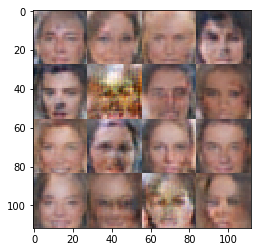

Epoch 0, batch 4610: discriminator loss 1.0107, generator loss 0.7946
Epoch 0, batch 4620: discriminator loss 1.0261, generator loss 0.7856
Epoch 0, batch 4630: discriminator loss 1.0087, generator loss 1.0513
Epoch 0, batch 4640: discriminator loss 0.9338, generator loss 1.3391
Epoch 0, batch 4650: discriminator loss 0.9060, generator loss 1.1467
Epoch 0, batch 4660: discriminator loss 0.9700, generator loss 0.9682
Epoch 0, batch 4670: discriminator loss 0.8509, generator loss 1.1173
Epoch 0, batch 4680: discriminator loss 1.0807, generator loss 0.7710
Epoch 0, batch 4690: discriminator loss 0.8210, generator loss 1.0393
Epoch 0, batch 4700: discriminator loss 1.2404, generator loss 0.7803


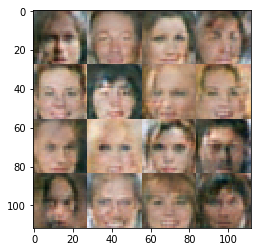

Epoch 0, batch 4710: discriminator loss 0.8212, generator loss 0.9699
Epoch 0, batch 4720: discriminator loss 0.8522, generator loss 1.0483
Epoch 0, batch 4730: discriminator loss 0.8842, generator loss 1.0739
Epoch 0, batch 4740: discriminator loss 0.9258, generator loss 1.0135
Epoch 0, batch 4750: discriminator loss 0.6711, generator loss 1.3909
Epoch 0, batch 4760: discriminator loss 0.7692, generator loss 1.0568
Epoch 0, batch 4770: discriminator loss 0.9439, generator loss 0.8613
Epoch 0, batch 4780: discriminator loss 0.9283, generator loss 1.3489
Epoch 0, batch 4790: discriminator loss 1.0430, generator loss 0.7863
Epoch 0, batch 4800: discriminator loss 0.8085, generator loss 1.3774


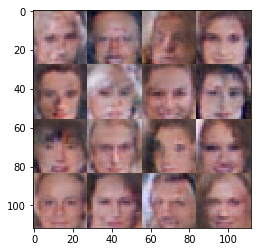

Epoch 0, batch 4810: discriminator loss 0.7034, generator loss 1.1466
Epoch 0, batch 4820: discriminator loss 0.9169, generator loss 1.0456
Epoch 0, batch 4830: discriminator loss 0.8671, generator loss 1.0123
Epoch 0, batch 4840: discriminator loss 0.8511, generator loss 1.2695
Epoch 0, batch 4850: discriminator loss 1.0854, generator loss 0.8827
Epoch 0, batch 4860: discriminator loss 0.9758, generator loss 1.1779
Epoch 0, batch 4870: discriminator loss 0.9601, generator loss 0.9663
Epoch 0, batch 4880: discriminator loss 0.9267, generator loss 0.8636
Epoch 0, batch 4890: discriminator loss 0.8755, generator loss 1.0597
Epoch 0, batch 4900: discriminator loss 1.0934, generator loss 0.7596


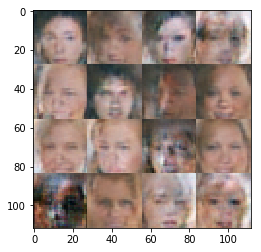

Epoch 0, batch 4910: discriminator loss 0.9864, generator loss 0.8401
Epoch 0, batch 4920: discriminator loss 1.1098, generator loss 0.7826
Epoch 0, batch 4930: discriminator loss 1.0377, generator loss 0.8516
Epoch 0, batch 4940: discriminator loss 0.8907, generator loss 1.0829
Epoch 0, batch 4950: discriminator loss 1.0871, generator loss 0.7684
Epoch 0, batch 4960: discriminator loss 0.8550, generator loss 1.1785
Epoch 0, batch 4970: discriminator loss 0.8911, generator loss 0.8627
Epoch 0, batch 4980: discriminator loss 0.8909, generator loss 1.3048
Epoch 0, batch 4990: discriminator loss 0.9090, generator loss 1.0080
Epoch 0, batch 5000: discriminator loss 1.5439, generator loss 0.4363


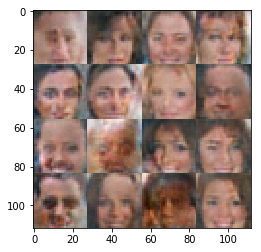

Epoch 0, batch 5010: discriminator loss 1.0007, generator loss 0.8740
Epoch 0, batch 5020: discriminator loss 1.0003, generator loss 0.9083
Epoch 0, batch 5030: discriminator loss 0.9691, generator loss 0.7849
Epoch 0, batch 5040: discriminator loss 0.9964, generator loss 0.9012
Epoch 0, batch 5050: discriminator loss 0.6836, generator loss 1.3329
Epoch 0, batch 5060: discriminator loss 0.9373, generator loss 0.9930
Epoch 0, batch 5070: discriminator loss 0.9808, generator loss 1.5782
Epoch 0, batch 5080: discriminator loss 0.8353, generator loss 1.0731
Epoch 0, batch 5090: discriminator loss 1.0152, generator loss 0.8767
Epoch 0, batch 5100: discriminator loss 0.7819, generator loss 1.1231


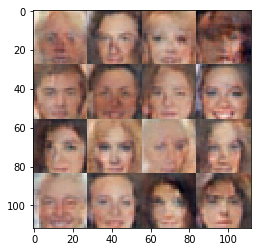

Epoch 0, batch 5110: discriminator loss 0.9826, generator loss 0.8046
Epoch 0, batch 5120: discriminator loss 0.8936, generator loss 1.0004
Epoch 0, batch 5130: discriminator loss 1.0389, generator loss 0.8426
Epoch 0, batch 5140: discriminator loss 1.0338, generator loss 1.2432
Epoch 0, batch 5150: discriminator loss 0.8900, generator loss 1.0504
Epoch 0, batch 5160: discriminator loss 1.0152, generator loss 0.8228
Epoch 0, batch 5170: discriminator loss 0.9466, generator loss 0.9110
Epoch 0, batch 5180: discriminator loss 0.8321, generator loss 1.1758
Epoch 0, batch 5190: discriminator loss 0.9564, generator loss 0.8786
Epoch 0, batch 5200: discriminator loss 0.9006, generator loss 0.9187


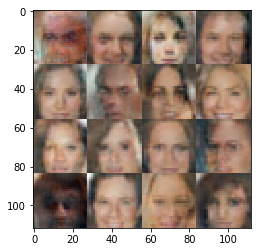

Epoch 0, batch 5210: discriminator loss 0.9601, generator loss 0.9966
Epoch 0, batch 5220: discriminator loss 0.8460, generator loss 0.9796
Epoch 0, batch 5230: discriminator loss 0.8943, generator loss 1.0030
Epoch 0, batch 5240: discriminator loss 0.9337, generator loss 0.9605
Epoch 0, batch 5250: discriminator loss 1.0257, generator loss 0.7918
Epoch 0, batch 5260: discriminator loss 0.9924, generator loss 1.0122
Epoch 0, batch 5270: discriminator loss 0.8380, generator loss 1.0847
Epoch 0, batch 5280: discriminator loss 0.8910, generator loss 1.2615
Epoch 0, batch 5290: discriminator loss 0.8894, generator loss 1.2029
Epoch 0, batch 5300: discriminator loss 0.9183, generator loss 1.0263


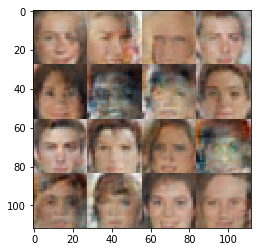

Epoch 0, batch 5310: discriminator loss 0.8518, generator loss 0.9446
Epoch 0, batch 5320: discriminator loss 0.8756, generator loss 0.9189
Epoch 0, batch 5330: discriminator loss 0.8971, generator loss 1.0481
Epoch 0, batch 5340: discriminator loss 0.9456, generator loss 0.8647
Epoch 0, batch 5350: discriminator loss 0.8815, generator loss 1.0110
Epoch 0, batch 5360: discriminator loss 0.9753, generator loss 0.8616
Epoch 0, batch 5370: discriminator loss 1.0582, generator loss 0.6980
Epoch 0, batch 5380: discriminator loss 1.0298, generator loss 0.7707
Epoch 0, batch 5390: discriminator loss 0.8658, generator loss 1.1457
Epoch 0, batch 5400: discriminator loss 0.7615, generator loss 1.3168


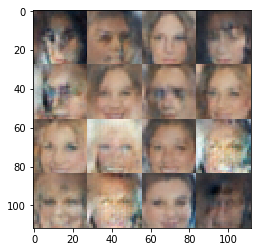

Epoch 0, batch 5410: discriminator loss 0.7835, generator loss 1.0673
Epoch 0, batch 5420: discriminator loss 0.8124, generator loss 1.1057
Epoch 0, batch 5430: discriminator loss 0.8065, generator loss 1.2368
Epoch 0, batch 5440: discriminator loss 0.9906, generator loss 0.8716
Epoch 0, batch 5450: discriminator loss 0.9915, generator loss 0.7976
Epoch 0, batch 5460: discriminator loss 0.8901, generator loss 0.9947
Epoch 0, batch 5470: discriminator loss 0.5832, generator loss 1.3114
Epoch 0, batch 5480: discriminator loss 1.0264, generator loss 1.0771
Epoch 0, batch 5490: discriminator loss 0.9863, generator loss 1.0726
Epoch 0, batch 5500: discriminator loss 0.7200, generator loss 1.3886


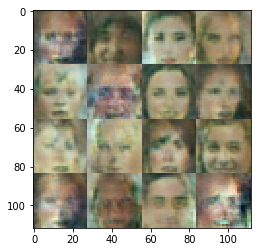

Epoch 0, batch 5510: discriminator loss 0.7164, generator loss 1.1312
Epoch 0, batch 5520: discriminator loss 0.8461, generator loss 1.0241
Epoch 0, batch 5530: discriminator loss 1.2524, generator loss 1.0423
Epoch 0, batch 5540: discriminator loss 0.8016, generator loss 1.3635
Epoch 0, batch 5550: discriminator loss 1.0171, generator loss 0.7911
Epoch 0, batch 5560: discriminator loss 1.0412, generator loss 1.0802
Epoch 0, batch 5570: discriminator loss 0.9370, generator loss 0.9843
Epoch 0, batch 5580: discriminator loss 0.9893, generator loss 0.8075
Epoch 0, batch 5590: discriminator loss 1.0077, generator loss 0.9386
Epoch 0, batch 5600: discriminator loss 0.9514, generator loss 0.8329


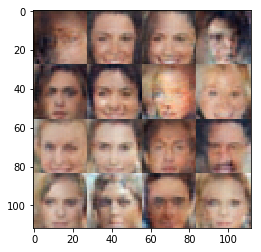

Epoch 0, batch 5610: discriminator loss 0.8507, generator loss 1.0707
Epoch 0, batch 5620: discriminator loss 1.0604, generator loss 0.9001
Epoch 0, batch 5630: discriminator loss 0.7694, generator loss 1.2402
Epoch 0, batch 5640: discriminator loss 0.8049, generator loss 1.1679
Epoch 0, batch 5650: discriminator loss 0.8794, generator loss 1.1061
Epoch 0, batch 5660: discriminator loss 1.0038, generator loss 0.8657
Epoch 0, batch 5670: discriminator loss 0.9388, generator loss 0.9468
Epoch 0, batch 5680: discriminator loss 0.9309, generator loss 1.0876
Epoch 0, batch 5690: discriminator loss 0.9429, generator loss 1.1790
Epoch 0, batch 5700: discriminator loss 1.0162, generator loss 0.8764


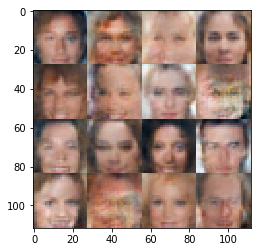

Epoch 0, batch 5710: discriminator loss 0.7796, generator loss 1.0764
Epoch 0, batch 5720: discriminator loss 0.8572, generator loss 1.0050
Epoch 0, batch 5730: discriminator loss 0.9293, generator loss 1.0621
Epoch 0, batch 5740: discriminator loss 1.0030, generator loss 1.0142
Epoch 0, batch 5750: discriminator loss 1.0941, generator loss 0.9032
Epoch 0, batch 5760: discriminator loss 0.7834, generator loss 1.0829
Epoch 0, batch 5770: discriminator loss 0.8283, generator loss 1.0495
Epoch 0, batch 5780: discriminator loss 0.8661, generator loss 1.1477
Epoch 0, batch 5790: discriminator loss 0.9544, generator loss 0.9895
Epoch 0, batch 5800: discriminator loss 0.9866, generator loss 0.8765


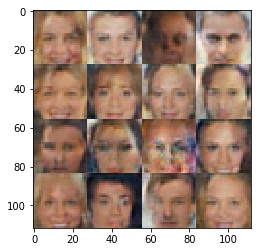

Epoch 0, batch 5810: discriminator loss 0.8386, generator loss 1.9234
Epoch 0, batch 5820: discriminator loss 0.8626, generator loss 1.0268
Epoch 0, batch 5830: discriminator loss 0.8638, generator loss 1.0782
Epoch 0, batch 5840: discriminator loss 1.2626, generator loss 0.6402
Epoch 0, batch 5850: discriminator loss 0.7880, generator loss 0.9882
Epoch 0, batch 5860: discriminator loss 0.9679, generator loss 0.9076
Epoch 0, batch 5870: discriminator loss 0.9530, generator loss 1.1597
Epoch 0, batch 5880: discriminator loss 0.9434, generator loss 0.9378
Epoch 0, batch 5890: discriminator loss 1.0486, generator loss 0.7243
Epoch 0, batch 5900: discriminator loss 0.8426, generator loss 1.0716


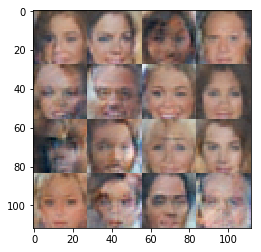

Epoch 0, batch 5910: discriminator loss 0.8986, generator loss 1.4909
Epoch 0, batch 5920: discriminator loss 0.8110, generator loss 1.0156
Epoch 0, batch 5930: discriminator loss 0.9460, generator loss 0.9009
Epoch 0, batch 5940: discriminator loss 0.8638, generator loss 1.0583
Epoch 0, batch 5950: discriminator loss 0.9270, generator loss 1.0956
Epoch 0, batch 5960: discriminator loss 0.9527, generator loss 1.0413
Epoch 0, batch 5970: discriminator loss 0.9136, generator loss 1.0898
Epoch 0, batch 5980: discriminator loss 0.9643, generator loss 0.8744
Epoch 0, batch 5990: discriminator loss 1.1397, generator loss 0.7898
Epoch 0, batch 6000: discriminator loss 1.0623, generator loss 0.7233


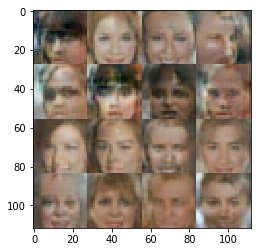

Epoch 0, batch 6010: discriminator loss 0.9736, generator loss 0.7614
Epoch 0, batch 6020: discriminator loss 0.7842, generator loss 1.0773
Epoch 0, batch 6030: discriminator loss 0.9033, generator loss 0.9795
Epoch 0, batch 6040: discriminator loss 1.0598, generator loss 0.8164
Epoch 0, batch 6050: discriminator loss 0.9286, generator loss 1.3819
Epoch 0, batch 6060: discriminator loss 1.0067, generator loss 0.7809
Epoch 0, batch 6070: discriminator loss 1.0497, generator loss 0.9358
Epoch 0, batch 6080: discriminator loss 1.1624, generator loss 0.7879
Epoch 0, batch 6090: discriminator loss 0.9215, generator loss 0.8256
Epoch 0, batch 6100: discriminator loss 0.8882, generator loss 0.9829


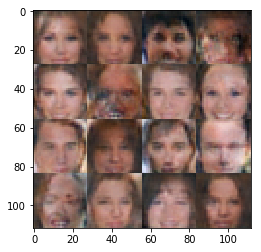

Epoch 0, batch 6110: discriminator loss 1.0998, generator loss 0.7299
Epoch 0, batch 6120: discriminator loss 0.9385, generator loss 0.8559
Epoch 0, batch 6130: discriminator loss 0.7767, generator loss 1.1033
Epoch 0, batch 6140: discriminator loss 1.0632, generator loss 1.1242
Epoch 0, batch 6150: discriminator loss 0.7506, generator loss 1.2144
Epoch 0, batch 6160: discriminator loss 1.0965, generator loss 0.7525
Epoch 0, batch 6170: discriminator loss 0.9405, generator loss 0.9951
Epoch 0, batch 6180: discriminator loss 1.0399, generator loss 1.3874
Epoch 0, batch 6190: discriminator loss 0.7947, generator loss 1.1093
Epoch 0, batch 6200: discriminator loss 0.8795, generator loss 1.0657


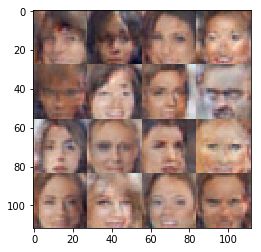

Epoch 0, batch 6210: discriminator loss 1.2308, generator loss 0.8379
Epoch 0, batch 6220: discriminator loss 1.0138, generator loss 0.9782
Epoch 0, batch 6230: discriminator loss 0.7781, generator loss 1.0063
Epoch 0, batch 6240: discriminator loss 1.0008, generator loss 1.2476
Epoch 0, batch 6250: discriminator loss 1.2099, generator loss 0.7332
Epoch 0, batch 6260: discriminator loss 0.9050, generator loss 0.8484
Epoch 0, batch 6270: discriminator loss 0.8359, generator loss 1.0576
Epoch 0, batch 6280: discriminator loss 0.7537, generator loss 1.2051
Epoch 0, batch 6290: discriminator loss 1.1111, generator loss 0.9367
Epoch 0, batch 6300: discriminator loss 1.0433, generator loss 0.7422


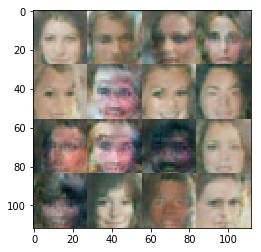

Epoch 0, batch 6310: discriminator loss 0.8489, generator loss 1.1110
Epoch 0, batch 6320: discriminator loss 0.8316, generator loss 0.9969
Epoch 0, batch 6330: discriminator loss 0.9433, generator loss 0.8408


In [99]:
batch_size = 32
z_dim = 200
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.